In [1364]:
#Importing Libraries

import pandas as pd
import matplotlib.pyplot as plt
from numpy import mean, std
import numpy as np
import seaborn as sns
import re
import warnings
from sklearn.linear_model import LinearRegression,ridge_regression
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RepeatedKFold
from scipy.stats import skew,kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


#Extra settings
pd.set_option('display.max_columns',None) # Will not truncate the display of columns 
pd.set_option('display.max_colwidth',None)
pd.set_option('display.max_rows',None) 
warnings.filterwarnings("ignore")
# np.set_printoptions(linewidth=10) 

In [1365]:
pip install --upgrade scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1366]:
#Loading train and test data
try:
    train_df=pd.read_csv('/home/anuragverma/Desktop/Kaggle/Kaggle--House-Prediction/Dataset/train.csv')
    test_df=pd.read_csv('/home/anuragverma/Desktop/Kaggle/Kaggle--House-Prediction/Dataset/test.csv')
    print("Train df shape: " ,train_df.shape)
    print("Test df shape: ", test_df.shape)

except FileNotFoundError:
    print("File not found")

Train df shape:  (1460, 81)
Test df shape:  (1459, 80)


In [1367]:
#train
numeric_df=train_df.select_dtypes(include='number')
numeric_df_cols=[col for col in numeric_df.columns]

numeric_df_cols.remove('MSSubClass')
numeric_df_cols.remove('MoSold')

numeric_df_updated=numeric_df[numeric_df_cols]
numeric_df_saleprice=numeric_df_updated['SalePrice']
numeric_df_updated_train=numeric_df_updated.drop('SalePrice',axis=1)

#test

numeric_df_test=test_df.select_dtypes(include='number')
numeric_df_test_cols=[col for col in numeric_df_test.columns]
numeric_df_test_cols.remove('MSSubClass')
numeric_df_test_cols.remove('MoSold')

numeric_df_updated_test=test_df[numeric_df_test_cols]
numeric_df_updated_test=numeric_df_updated_test


In [1368]:
#Removing Null
numeric_df_updated_train=numeric_df_updated_train.fillna(0)
numeric_df_updated_test=numeric_df_updated_test.fillna(0)

numeric_df_updated_train_Id=numeric_df_updated_train['Id']
numeric_df_updated_test_Id=numeric_df_updated_test['Id']
numeric_df_updated_train=numeric_df_updated_train.drop('Id',axis=1)
numeric_df_updated_test=numeric_df_updated_test.drop('Id',axis=1)


In [1369]:
# combined_df_model1_df = pd.concat([train_df_numeric, test_df_numeric], axis=0, ignore_index=True)
numeric_df_updated_test.head(5)
print(numeric_df_updated_train.shape,numeric_df_updated_test.shape)

(1460, 34) (1459, 34)


In [1370]:
#Create pipeline
rfe = RFE(estimator=LinearRegression(),n_features_to_select=1)
model=LinearRegression()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])

# evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores = cross_val_score(pipeline, numeric_df_updated_train, numeric_df_saleprice, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Model 1:','MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Model 1: MAE: -33765.293 (2517.736)


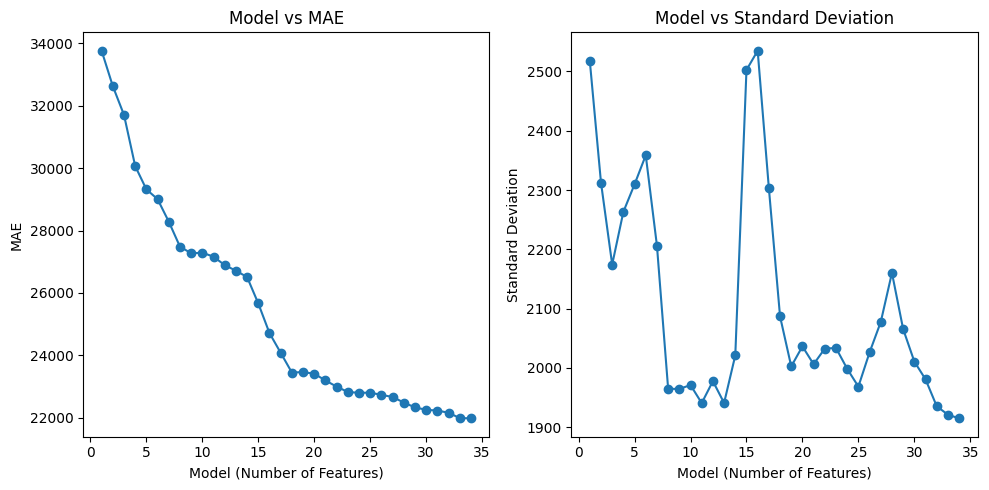

Around 15-20 features seems to be a good starting point. MAE has plateaued, and the standard deviation, while
not the absolute lowest, is relatively stable in this range.
Features beyond 20 offer minimal MAE improvement and come with more erratic standard deviation.
This suggests overfitting - the model might be picking up noise in the data rather than true patterns.



In [1371]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold, cross_val_score
from numpy import mean, std

Final_col = [col for col in numeric_df_updated_train.columns]
selected_features_dict = {}  # Store selected features for each model
Final_eval=[]

for i in range(1, len(Final_col) + 1):
    # Create pipeline
    rfe = RFE(estimator=LinearRegression(), n_features_to_select=i)
    model = LinearRegression()
    pipeline = Pipeline(steps=[('s', rfe), ('m', model)])

    # Evaluate model
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    n_scores = cross_val_score(pipeline, numeric_df_updated_train, numeric_df_saleprice, 
                                scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    
    # Fit the pipeline on all training data to get selected features
    pipeline.fit(numeric_df_updated_train, numeric_df_saleprice)
    selected_feature_indices = pipeline.named_steps['s'].support_
    selected_features = list(numeric_df_updated_train.columns[selected_feature_indices])
    selected_features_dict[i] = selected_features  # Store in the dictionary

    # Report performance
   # print(f'Model {i}: MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
    
    Final_eval.append({
        'Model': i,
        'MAE': -mean(n_scores),  # Negate to get positive MAE
        'Std Dev': std(n_scores),
        'Features': ', '.join(selected_features_dict[i])
    })

Final_eval_df=pd.DataFrame(Final_eval)

plt.figure(figsize=(10, 5))  # Adjust figure size as needed

# Plot Model vs MAE
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
plt.plot(Final_eval_df['Model'], Final_eval_df['MAE'], marker='o', linestyle='-')
plt.xlabel('Model (Number of Features)')
plt.ylabel('MAE')
plt.title('Model vs MAE')

# Plot Model vs Std Dev
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
plt.plot(Final_eval_df['Model'], Final_eval_df['Std Dev'], marker='o', linestyle='-')
plt.xlabel('Model (Number of Features)')
plt.ylabel('Standard Deviation')
plt.title('Model vs Standard Deviation')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


# # Print selected features for each model
# for i in range(1, len(Final_col) + 1):
#     print(f"Model {i} - Selected Features: {selected_features_dict[i]}")

print('Around 15-20 features seems to be a good starting point. MAE has plateaued, and the standard deviation, while\n\
not the absolute lowest, is relatively stable in this range.\n\
Features beyond 20 offer minimal MAE improvement and come with more erratic standard deviation.\n\
This suggests overfitting - the model might be picking up noise in the data rather than true patterns.\n')



In [1372]:
#Features to use
Final_eval_df[Final_eval_df['Model']==20]

,Model,MAE,Std Dev,Features
19,20,23408.318669,2036.276027,"LotFrontage, OverallQual, OverallCond, YearBuilt, YearRemodAdd, MasVnrArea, 1stFlrSF, 2ndFlrSF, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageCars, ScreenPorch, PoolArea, YrSold"


In [1373]:
#Benchmark model
model1=LinearRegression()
model1.fit(numeric_df_updated_train, numeric_df_saleprice)
y_pred_model1=model1.predict(numeric_df_updated_test)
y_pred_model1_df=pd.DataFrame(y_pred_model1)
y_pred_model1_df.to_csv('/home/anuragverma/Desktop/Kaggle/Kaggle--House-Prediction/Predictions/model3.csv')

In [1374]:
#Using 20 features 
Final_eval_df_20=Final_eval_df[Final_eval_df['Model']==20]
cols_from_RFE=list(Final_eval_df_20['Features'])
cols_from_RFE = cols_from_RFE[0].split(', ')
numeric_df_updated_train_20_feat=numeric_df_updated_train[cols_from_RFE]
numeric_df_updated_test_20_feat=numeric_df_updated_test[cols_from_RFE]

#model 2
model2=LinearRegression()
model2.fit(numeric_df_updated_train_20_feat, numeric_df_saleprice)
y_pred_model2=model2.predict(numeric_df_updated_test_20_feat)
y_pred_model2_df=pd.DataFrame(y_pred_model2)
y_pred_model2_df.to_csv('/home/anuragverma/Desktop/Kaggle/Kaggle--House-Prediction/Predictions/model4.csv')

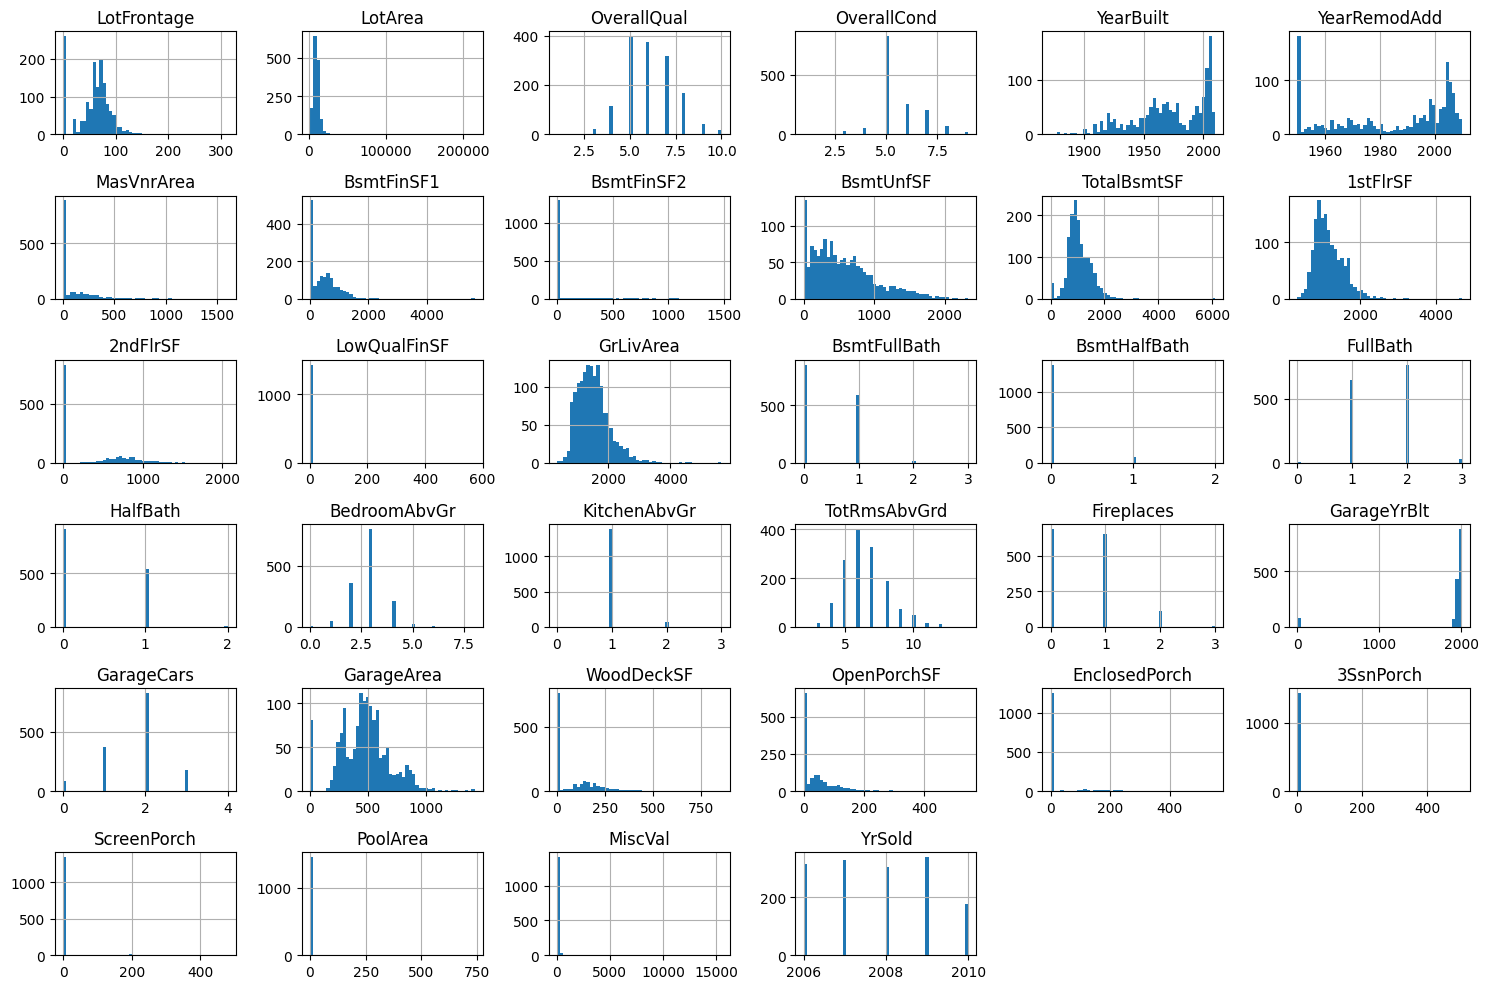

In [1375]:
#Caculate skewness and kurtosis for all nuemrical cols on train data
skewness_values=numeric_df_updated_train.apply(skew)
kurtosis_values=numeric_df_updated_train.apply(kurtosis)

summary_df=pd.DataFrame({
    'Skewness':skewness_values,
    'kurtosis_values':kurtosis_values
},index=numeric_df_updated_train.columns)

#display(summary_df)

numeric_df_updated_train.hist(figsize=(15, 10), bins=50) 
plt.tight_layout()  # Prevent overlapping plots
plt.show() 

In [1376]:
#train
display(summary_df[(summary_df['Skewness']>=0.5)])

,Skewness,kurtosis_values
LotArea,12.195142,202.543793
OverallCond,0.692355,1.098521
MasVnrArea,2.674865,10.102612
BsmtFinSF1,1.683771,11.076090
BsmtFinSF2,4.250888,20.040415
BsmtUnfSF,0.919323,0.469262
TotalBsmtSF,1.522688,13.201042
1stFlrSF,1.375342,5.722076
2ndFlrSF,0.812194,-0.555677
LowQualFinSF,9.002080,82.945932


In [1377]:
#lets combine train and test 

combbined_train_test = pd.concat([numeric_df_updated_train, numeric_df_updated_test], axis=0, ignore_index=True)

skewness_values_combined=combbined_train_test.apply(skew)
kurtosis_values_combined=combbined_train_test.apply(kurtosis)

summary_df_combined=pd.DataFrame({
    'Skewness':skewness_values_combined,
    'kurtosis_values':kurtosis_values_combined
},index=combbined_train_test.columns)


In [1378]:
#train and test combined
display(summary_df_combined[(summary_df_combined['Skewness']>=0.5)])

,Skewness,kurtosis_values
LotArea,12.822431,264.496632
OverallCond,0.570312,1.474860
MasVnrArea,2.613592,9.318376
BsmtFinSF1,1.425230,6.890172
BsmtFinSF2,4.146143,18.810079
BsmtUnfSF,0.919339,0.400758
TotalBsmtSF,1.156894,9.105153
1stFlrSF,1.469604,6.942514
2ndFlrSF,0.861675,-0.423593
LowQualFinSF,12.088761,174.631256


In [1379]:
#Treating positive skewness with log transform

summary_df__comb_pos_skew=summary_df_combined[(summary_df_combined['Skewness']>=0.5)].index
summary_df__comb_pos_skew=list(summary_df__comb_pos_skew)

#first replace 0 values with 0.001 for log transform
combbined_train_test[summary_df__comb_pos_skew] = combbined_train_test[summary_df__comb_pos_skew].replace(0, 0.001)

# Apply the log1p transformation
combbined_train_test[summary_df__comb_pos_skew] = np.log1p(combbined_train_test[summary_df__comb_pos_skew]) 

In [1380]:
#skewness after log transform
skewness_values_combined=combbined_train_test.apply(skew)
kurtosis_values_combined=combbined_train_test.apply(kurtosis)

summary_df_combined=pd.DataFrame({
    'Skewness':skewness_values_combined,
    'kurtosis_values':kurtosis_values_combined
},index=combbined_train_test.columns)
display(summary_df_combined[(summary_df_combined['Skewness']>=0.5)])

,Skewness,kurtosis_values
MasVnrArea,0.537057,-1.584828
BsmtFinSF2,2.462517,4.245770
LowQualFinSF,8.557755,72.187017
BsmtHalfBath,3.774978,12.578496
HalfBath,0.580850,-1.544736
KitchenAbvGr,3.523575,20.212512
EnclosedPorch,1.961111,1.970117
3SsnPorch,8.825296,76.451207
ScreenPorch,2.945917,6.749862
PoolArea,14.998370,223.932313


In [1381]:
display(summary_df_combined[(summary_df_combined['Skewness']<=-0.5)])

,Skewness,kurtosis_values
LotArea,-0.504751,3.745614
OverallCond,-0.746183,6.131385
YearBuilt,-0.599806,-0.512497
BsmtFinSF1,-0.616589,-1.466150
BsmtUnfSF,-2.154996,3.949019
TotalBsmtSF,-4.956074,25.484034
GarageYrBlt,-3.906205,13.316886


In [1382]:
summary_df__comb_neg_skew=summary_df_combined[(summary_df_combined['Skewness']<=-0.5)].index
summary_df__comb_neg_skew=list(summary_df__comb_neg_skew)
summary_df__comb_neg_skew

# #treating negative skewed data
# combbined_train_test[summary_df__comb_neg_skew] = np.sqrt(combbined_train_test[summary_df__comb_neg_skew] + 0.001) 

['LotArea',
 'OverallCond',
 'YearBuilt',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'GarageYrBlt']

In [1383]:
# #skewness after log transform
# skewness_values_combined=combbined_train_test.apply(skew)
# kurtosis_values_combined=combbined_train_test.apply(kurtosis)

# summary_df_combined=pd.DataFrame({
#     'Skewness':skewness_values_combined,
#     'kurtosis_values':kurtosis_values_combined
# },index=combbined_train_test.columns)
# display(summary_df_combined[(summary_df_combined['Skewness']<=-0.5)])
# #Sqrt transform increased the skewness more so we wont use it

In [1384]:
negatively_skewed_cols = ['LotArea', 'OverallCond', 'YearBuilt', 
                         'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 
                         'GarageYrBlt']

for col in negatively_skewed_cols:
    # 1. Reflection (Mirroring)
    max_val = combbined_train_test[col].max() + 1 # Adding 1 to avoid potential issues with 0
    combbined_train_test[col + '_reflected'] = max_val - combbined_train_test[col]

    #If all the values in a column are negative try to treat negative skewness using the following: Experiment with removing abs and with abs
    # col = 'col'
    # min_val = combbined_train_test[col].min() - 1
    # combbined_train_test[col + '_reflected'] = abs(min_val - combbined_train_test[col]) 

    # 2. Apply Transformation (e.g., Cube Root)
    combbined_train_test[col + '_cbrt'] = np.cbrt(combbined_train_test[col + '_reflected'])

In [1385]:
combbined_train_test.head(5)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,LotArea_reflected,LotArea_cbrt,OverallCond_reflected,OverallCond_cbrt,YearBuilt_reflected,YearBuilt_cbrt,BsmtFinSF1_reflected,BsmtFinSF1_cbrt,BsmtUnfSF_reflected,BsmtUnfSF_cbrt,TotalBsmtSF_reflected,TotalBsmtSF_cbrt,GarageYrBlt_reflected,GarageYrBlt_cbrt
0,65.0,9.042040,7,1.791759,2003,2003,5.283204,6.561031,0.001,5.017280,6.753438,6.753438,6.751101,0.001,7.444833,0.693147,0.001000,2,0.693147,3,0.693147,2.197225,0.001000,2003.0,2.0,548.0,0.001000,4.127134,0.001000,0.001,0.001,0.001,0.001,2008,4.237497,1.618216,1.510826,1.147461,8,2.000000,3.077495,1.454563,3.739343,1.552143,2.964408,1.436523,205.0,5.896369
1,80.0,9.169623,6,2.197225,1976,1976,0.001000,6.886532,0.001,5.652489,7.141245,7.141245,0.001000,0.001,7.141245,0.001000,0.693147,2,0.001000,3,0.693147,1.945910,0.693147,1976.0,2.0,460.0,5.700444,0.001000,0.001000,0.001,0.001,0.001,0.001,2007,4.109914,1.601810,1.105361,1.033954,35,3.271066,2.751994,1.401358,3.104134,1.458748,2.576601,1.370931,232.0,6.144634
2,68.0,9.328212,7,1.791759,2001,2002,5.093750,6.188264,0.001,6.075346,6.825460,6.825460,6.765039,0.001,7.488294,0.693147,0.001000,2,0.693147,3,0.693147,1.945910,0.693147,2001.0,2.0,608.0,0.001000,3.761200,0.001000,0.001,0.001,0.001,0.001,2008,3.951325,1.580936,1.510826,1.147461,10,2.154435,3.450261,1.511068,2.681277,1.389251,2.892386,1.424794,207.0,5.915482
3,60.0,9.164401,7,1.791759,1915,1970,0.001000,5.379897,0.001,6.293419,6.629363,6.869014,6.629363,0.001,7.448916,0.693147,0.001000,1,0.001000,3,0.693147,2.079442,0.693147,1998.0,3.0,642.0,0.001000,3.583519,5.609472,0.001,0.001,0.001,0.001,2006,4.115136,1.602488,1.510826,1.147461,96,4.578857,4.258628,1.620901,2.463204,1.350517,3.088482,1.456292,210.0,5.943922
4,84.0,9.565284,8,1.791759,2000,2000,5.860786,6.486161,0.001,6.196444,7.044033,7.044033,6.960348,0.001,7.695758,0.693147,0.001000,2,0.693147,4,0.693147,2.302585,0.693147,2000.0,3.0,836.0,5.262690,4.442651,0.001000,0.001,0.001,0.001,0.001,2008,3.714253,1.548664,1.510826,1.147461,11,2.223980,3.152365,1.466264,2.560179,1.368013,2.673813,1.387960,208.0,5.924992


In [1386]:
#skewness after cbrt transform
skewness_values_combined=combbined_train_test.apply(skew)
kurtosis_values_combined=combbined_train_test.apply(kurtosis)

summary_df_combined=pd.DataFrame({
    'Skewness':skewness_values_combined,
    'kurtosis_values':kurtosis_values_combined
},index=combbined_train_test.columns)
display(summary_df_combined[(summary_df_combined['Skewness']<=-0.5)])

,Skewness,kurtosis_values
LotArea,-0.504751,3.745614
OverallCond,-0.746183,6.131385
YearBuilt,-0.599806,-0.512497
BsmtFinSF1,-0.616589,-1.466150
BsmtUnfSF,-2.154996,3.949019
TotalBsmtSF,-4.956074,25.484034
GarageYrBlt,-3.906205,13.316886


In [1387]:
#removing reflected cols
reflected_cols = [col for col in combbined_train_test.columns if col.endswith('_reflected')]
for col in reflected_cols:
    combbined_train_test=combbined_train_test.drop(col,axis=1)
    
#removing neg skew as these were treated with cbrt cols and created new cbrt cols
for col in negatively_skewed_cols:
    combbined_train_test=combbined_train_test.drop(col,axis=1)

In [1388]:
combbined_train_test.head(5)

,LotFrontage,OverallQual,YearRemodAdd,MasVnrArea,BsmtFinSF2,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,LotArea_cbrt,OverallCond_cbrt,YearBuilt_cbrt,BsmtFinSF1_cbrt,BsmtUnfSF_cbrt,TotalBsmtSF_cbrt,GarageYrBlt_cbrt
0,65.0,7,2003,5.283204,0.001,6.753438,6.751101,0.001,7.444833,0.693147,0.001000,2,0.693147,3,0.693147,2.197225,0.001000,2.0,548.0,0.001000,4.127134,0.001000,0.001,0.001,0.001,0.001,2008,1.618216,1.147461,2.000000,1.454563,1.552143,1.436523,5.896369
1,80.0,6,1976,0.001000,0.001,7.141245,0.001000,0.001,7.141245,0.001000,0.693147,2,0.001000,3,0.693147,1.945910,0.693147,2.0,460.0,5.700444,0.001000,0.001000,0.001,0.001,0.001,0.001,2007,1.601810,1.033954,3.271066,1.401358,1.458748,1.370931,6.144634
2,68.0,7,2002,5.093750,0.001,6.825460,6.765039,0.001,7.488294,0.693147,0.001000,2,0.693147,3,0.693147,1.945910,0.693147,2.0,608.0,0.001000,3.761200,0.001000,0.001,0.001,0.001,0.001,2008,1.580936,1.147461,2.154435,1.511068,1.389251,1.424794,5.915482
3,60.0,7,1970,0.001000,0.001,6.869014,6.629363,0.001,7.448916,0.693147,0.001000,1,0.001000,3,0.693147,2.079442,0.693147,3.0,642.0,0.001000,3.583519,5.609472,0.001,0.001,0.001,0.001,2006,1.602488,1.147461,4.578857,1.620901,1.350517,1.456292,5.943922
4,84.0,8,2000,5.860786,0.001,7.044033,6.960348,0.001,7.695758,0.693147,0.001000,2,0.693147,4,0.693147,2.302585,0.693147,3.0,836.0,5.262690,4.442651,0.001000,0.001,0.001,0.001,0.001,2008,1.548664,1.147461,2.223980,1.466264,1.368013,1.387960,5.924992


In [1389]:
#skewness after final transform
skewness_values_combined=combbined_train_test.apply(skew)
kurtosis_values_combined=combbined_train_test.apply(kurtosis)

summary_df_combined=pd.DataFrame({
    'Skewness':skewness_values_combined,
    'kurtosis_values':kurtosis_values_combined
},index=combbined_train_test.columns)
display(summary_df_combined[(summary_df_combined['Skewness']<=-0.5)])

#no negative skewness left

,Skewness,kurtosis_values


In [1390]:
combbined_train = combbined_train_test.iloc[:1460].reset_index(drop=True)
combbined_test = combbined_train_test.iloc[1460:].reset_index(drop=True)
print(combbined_train.shape,combbined_test.shape)

(1460, 34) (1459, 34)


In [1391]:
#model 3
model3=LinearRegression()
model3.fit(combbined_train, numeric_df_saleprice)
y_pred_model3=model3.predict(combbined_test)
y_pred_model3_df=pd.DataFrame(y_pred_model3)
y_pred_model3_df.to_csv('/home/anuragverma/Desktop/Kaggle/Kaggle--House-Prediction/Predictions/model4.csv')

In [1392]:
numeric_df_saleprice_log_transform=np.log(numeric_df_saleprice)

In [1393]:
#model 4

model4=LinearRegression()
model4.fit(combbined_train, numeric_df_saleprice_log_transform)
y_pred_model4=model4.predict(combbined_test)
y_pred_model4_df=pd.DataFrame(y_pred_model4)
restored_values_y_pred_model4 = np.exp(y_pred_model4_df)
restored_values_y_pred_model4.to_csv('/home/anuragverma/Desktop/Kaggle/Kaggle--House-Prediction/Predictions/model5.csv')
#Best till now:- 0.13636

In [1394]:
combbined_train_test.head(5)
#We will be adding year cols to calculate age

,LotFrontage,OverallQual,YearRemodAdd,MasVnrArea,BsmtFinSF2,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,LotArea_cbrt,OverallCond_cbrt,YearBuilt_cbrt,BsmtFinSF1_cbrt,BsmtUnfSF_cbrt,TotalBsmtSF_cbrt,GarageYrBlt_cbrt
0,65.0,7,2003,5.283204,0.001,6.753438,6.751101,0.001,7.444833,0.693147,0.001000,2,0.693147,3,0.693147,2.197225,0.001000,2.0,548.0,0.001000,4.127134,0.001000,0.001,0.001,0.001,0.001,2008,1.618216,1.147461,2.000000,1.454563,1.552143,1.436523,5.896369
1,80.0,6,1976,0.001000,0.001,7.141245,0.001000,0.001,7.141245,0.001000,0.693147,2,0.001000,3,0.693147,1.945910,0.693147,2.0,460.0,5.700444,0.001000,0.001000,0.001,0.001,0.001,0.001,2007,1.601810,1.033954,3.271066,1.401358,1.458748,1.370931,6.144634
2,68.0,7,2002,5.093750,0.001,6.825460,6.765039,0.001,7.488294,0.693147,0.001000,2,0.693147,3,0.693147,1.945910,0.693147,2.0,608.0,0.001000,3.761200,0.001000,0.001,0.001,0.001,0.001,2008,1.580936,1.147461,2.154435,1.511068,1.389251,1.424794,5.915482
3,60.0,7,1970,0.001000,0.001,6.869014,6.629363,0.001,7.448916,0.693147,0.001000,1,0.001000,3,0.693147,2.079442,0.693147,3.0,642.0,0.001000,3.583519,5.609472,0.001,0.001,0.001,0.001,2006,1.602488,1.147461,4.578857,1.620901,1.350517,1.456292,5.943922
4,84.0,8,2000,5.860786,0.001,7.044033,6.960348,0.001,7.695758,0.693147,0.001000,2,0.693147,4,0.693147,2.302585,0.693147,3.0,836.0,5.262690,4.442651,0.001000,0.001,0.001,0.001,0.001,2008,1.548664,1.147461,2.223980,1.466264,1.368013,1.387960,5.924992


In [1395]:
train_df[['YearBuilt','YearRemodAdd','GarageYrBlt','SalePrice']].head(5)

,YearBuilt,YearRemodAdd,GarageYrBlt,SalePrice
0,2003,2003,2003.0,208500
1,1976,1976,1976.0,181500
2,2001,2002,2001.0,223500
3,1915,1970,1998.0,140000
4,2000,2000,2000.0,250000


In [1396]:
train_df_corr=train_df[['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold','SalePrice']].corr()
train_df_corr

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,SalePrice
YearBuilt,1.000000,0.592855,0.825667,-0.013618,0.522897
YearRemodAdd,0.592855,1.000000,0.642277,0.035743,0.507101
GarageYrBlt,0.825667,0.642277,1.000000,-0.001014,0.486362
YrSold,-0.013618,0.035743,-0.001014,1.000000,-0.028923
SalePrice,0.522897,0.507101,0.486362,-0.028923,1.000000


In [1397]:
dummy_df_years=pd.concat([train_df,test_df],axis=0)
dummy_df_years.shape

(2919, 81)

In [1398]:
dummy_df_years['YrSinceBuilt']=dummy_df_years['YrSold']-dummy_df_years['YearBuilt']
dummy_df_years['YrSinceGarageBuilt']=dummy_df_years['YrSold']-dummy_df_years['GarageYrBlt']
dummy_df_years['YrSinceRemod']=dummy_df_years['YrSold']-dummy_df_years['YearRemodAdd']

In [1399]:
dummy_df_years_corr=dummy_df_years[['YrSinceBuilt','YrSinceGarageBuilt','YrSinceRemod','SalePrice']].corr()
dummy_df_years_corr
#YrSinceGarageBuilt and YrSinceBuilt showing multicollinearity. We will build 2 model. 
# one with both the cols and the other with YrSinceGarageBuilt removed.

,YrSinceBuilt,YrSinceGarageBuilt,YrSinceRemod,SalePrice
YrSinceBuilt,1.000000,0.835213,0.613463,-0.523350
YrSinceGarageBuilt,0.835213,1.000000,0.653210,-0.487069
YrSinceRemod,0.613463,0.653210,1.000000,-0.509079
SalePrice,-0.523350,-0.487069,-0.509079,1.000000


In [1400]:
dummy_df_years_df=dummy_df_years[['YrSinceBuilt','YrSinceGarageBuilt','YrSinceRemod']]
dummy_df_years_df=dummy_df_years_df.fillna(0)
dummy_df_years_df_skew=dummy_df_years_df.apply(skew)
dummy_df_years_df_skew

YrSinceBuilt          0.598609
YrSinceGarageBuilt    0.454004
YrSinceRemod          0.450226
dtype: float64

In [1401]:
dummy_df_years_df.shape

(2919, 3)

In [1402]:
dummy_df_years_df_skew=dummy_df_years_df.apply(skew)
dummy_df_years_df_skew

YrSinceBuilt          0.598609
YrSinceGarageBuilt    0.454004
YrSinceRemod          0.450226
dtype: float64

In [1403]:
col_to_Drop=['YearRemodAdd','YrSold','GarageYrBlt_cbrt','YearBuilt_cbrt']
for col in col_to_Drop:
    combbined_train_test=combbined_train_test.drop(col,axis=1)

In [1404]:
# combbined_train_test=pd.concat([combbined_train_test,dummy_df_years_df],axis=0)
combbined_train_test.shape

(2919, 30)

In [1405]:
combbined_train_test.head(5)

,LotFrontage,OverallQual,MasVnrArea,BsmtFinSF2,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,LotArea_cbrt,OverallCond_cbrt,BsmtFinSF1_cbrt,BsmtUnfSF_cbrt,TotalBsmtSF_cbrt
0,65.0,7,5.283204,0.001,6.753438,6.751101,0.001,7.444833,0.693147,0.001000,2,0.693147,3,0.693147,2.197225,0.001000,2.0,548.0,0.001000,4.127134,0.001000,0.001,0.001,0.001,0.001,1.618216,1.147461,1.454563,1.552143,1.436523
1,80.0,6,0.001000,0.001,7.141245,0.001000,0.001,7.141245,0.001000,0.693147,2,0.001000,3,0.693147,1.945910,0.693147,2.0,460.0,5.700444,0.001000,0.001000,0.001,0.001,0.001,0.001,1.601810,1.033954,1.401358,1.458748,1.370931
2,68.0,7,5.093750,0.001,6.825460,6.765039,0.001,7.488294,0.693147,0.001000,2,0.693147,3,0.693147,1.945910,0.693147,2.0,608.0,0.001000,3.761200,0.001000,0.001,0.001,0.001,0.001,1.580936,1.147461,1.511068,1.389251,1.424794
3,60.0,7,0.001000,0.001,6.869014,6.629363,0.001,7.448916,0.693147,0.001000,1,0.001000,3,0.693147,2.079442,0.693147,3.0,642.0,0.001000,3.583519,5.609472,0.001,0.001,0.001,0.001,1.602488,1.147461,1.620901,1.350517,1.456292
4,84.0,8,5.860786,0.001,7.044033,6.960348,0.001,7.695758,0.693147,0.001000,2,0.693147,4,0.693147,2.302585,0.693147,3.0,836.0,5.262690,4.442651,0.001000,0.001,0.001,0.001,0.001,1.548664,1.147461,1.466264,1.368013,1.387960


In [1406]:
dummy_df_years_df.shape

(2919, 3)

In [1407]:
combined_df = pd.concat([dummy_df_years_df, combbined_train_test], axis=0)

In [1408]:
print(dummy_df_years_df.shape)
print(combbined_train_test.shape)

(2919, 3)
(2919, 30)


In [1409]:
dummy_df_years_df = dummy_df_years_df.reset_index(drop=True)
combbined_train_test = combbined_train_test.reset_index(drop=True)
combined_df = pd.concat([dummy_df_years_df, combbined_train_test], axis=1)

In [1410]:
combined_df.shape

(2919, 33)

In [1411]:
combined_df.head(5)

,YrSinceBuilt,YrSinceGarageBuilt,YrSinceRemod,LotFrontage,OverallQual,MasVnrArea,BsmtFinSF2,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,LotArea_cbrt,OverallCond_cbrt,BsmtFinSF1_cbrt,BsmtUnfSF_cbrt,TotalBsmtSF_cbrt
0,5,5.0,5,65.0,7,5.283204,0.001,6.753438,6.751101,0.001,7.444833,0.693147,0.001000,2,0.693147,3,0.693147,2.197225,0.001000,2.0,548.0,0.001000,4.127134,0.001000,0.001,0.001,0.001,0.001,1.618216,1.147461,1.454563,1.552143,1.436523
1,31,31.0,31,80.0,6,0.001000,0.001,7.141245,0.001000,0.001,7.141245,0.001000,0.693147,2,0.001000,3,0.693147,1.945910,0.693147,2.0,460.0,5.700444,0.001000,0.001000,0.001,0.001,0.001,0.001,1.601810,1.033954,1.401358,1.458748,1.370931
2,7,7.0,6,68.0,7,5.093750,0.001,6.825460,6.765039,0.001,7.488294,0.693147,0.001000,2,0.693147,3,0.693147,1.945910,0.693147,2.0,608.0,0.001000,3.761200,0.001000,0.001,0.001,0.001,0.001,1.580936,1.147461,1.511068,1.389251,1.424794
3,91,8.0,36,60.0,7,0.001000,0.001,6.869014,6.629363,0.001,7.448916,0.693147,0.001000,1,0.001000,3,0.693147,2.079442,0.693147,3.0,642.0,0.001000,3.583519,5.609472,0.001,0.001,0.001,0.001,1.602488,1.147461,1.620901,1.350517,1.456292
4,8,8.0,8,84.0,8,5.860786,0.001,7.044033,6.960348,0.001,7.695758,0.693147,0.001000,2,0.693147,4,0.693147,2.302585,0.693147,3.0,836.0,5.262690,4.442651,0.001000,0.001,0.001,0.001,0.001,1.548664,1.147461,1.466264,1.368013,1.387960


In [1412]:
combbined_train_after_ageadd = combined_df.iloc[:1460].reset_index(drop=True)
combbined_test_after_ageadd = combined_df.iloc[1460:].reset_index(drop=True)

In [1413]:
print(combbined_train_after_ageadd.shape)
print(combbined_test_after_ageadd.shape)

(1460, 33)
(1459, 33)


In [1414]:
test_df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [1415]:
combbined_test_after_ageadd.head(5)

,YrSinceBuilt,YrSinceGarageBuilt,YrSinceRemod,LotFrontage,OverallQual,MasVnrArea,BsmtFinSF2,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,LotArea_cbrt,OverallCond_cbrt,BsmtFinSF1_cbrt,BsmtUnfSF_cbrt,TotalBsmtSF_cbrt
0,49,49.0,49,80.0,5,0.001000,4.976734,6.799056,0.001000,0.001,6.799056,0.001,0.001,1,0.001000,2,0.693147,1.791759,0.001000,1.0,730.0,4.948760,0.001000,0.001,0.001,4.795791,0.001,0.001000,1.576586,1.107028,1.516546,1.466596,1.431679
1,52,52.0,52,81.0,6,4.691348,0.001000,7.192934,0.001000,0.001,7.192934,0.001,0.001,1,0.693147,3,0.693147,1.945910,0.001000,1.0,312.0,5.976351,3.610918,0.001,0.001,0.001000,0.001,9.433564,1.548596,1.107028,1.411104,1.400648,1.361702
2,13,13.0,12,74.0,5,0.001000,0.001000,6.834109,6.553933,0.001,7.396335,0.001,0.001,2,0.693147,3,0.693147,1.945910,0.693147,2.0,482.0,5.361292,3.555348,0.001,0.001,0.001000,0.001,0.001000,1.552907,1.147461,1.436452,1.564501,1.423372
3,12,12.0,12,78.0,6,3.044522,0.001000,6.831954,6.520621,0.001,7.380879,0.001,0.001,2,0.693147,3,0.693147,2.079442,0.693147,2.0,470.0,5.888878,3.610918,0.001,0.001,0.001000,0.001,0.001000,1.596777,1.107028,1.479211,1.437877,1.423727
4,18,18.0,18,43.0,8,0.001000,0.001000,7.155396,0.001000,0.001,7.155396,0.001,0.001,2,0.001000,2,0.693147,1.791759,0.001000,2.0,506.0,0.001000,4.418841,0.001,0.001,4.976734,0.001,0.001000,1.682301,1.147461,1.595636,1.223390,1.368417


In [1416]:
#model 5

model5=LinearRegression()
model5.fit(combbined_train_after_ageadd, numeric_df_saleprice_log_transform)
y_pred_model5=model5.predict(combbined_test_after_ageadd)
y_pred_model5_df=pd.DataFrame(y_pred_model5)
restored_values_y_pred_model5 = np.exp(y_pred_model5_df)
restored_values_y_pred_model5.to_csv('/home/anuragverma/Desktop/Kaggle/Kaggle--House-Prediction/Predictions/model6.csv')

In [1417]:
#Removing yrsince garage built
combbined_train_after_ageadd=combbined_train_after_ageadd.drop('YrSinceGarageBuilt',axis=1)

In [1418]:
combbined_test_after_ageadd=combbined_test_after_ageadd.drop('YrSinceGarageBuilt',axis=1)

In [1419]:
#model 6

model6=LinearRegression()
model6.fit(combbined_train_after_ageadd, numeric_df_saleprice_log_transform)
y_pred_model6=model6.predict(combbined_test_after_ageadd)
y_pred_model6_df=pd.DataFrame(y_pred_model6)
restored_values_y_pred_model6 = np.exp(y_pred_model6_df)
restored_values_y_pred_model6.to_csv('/home/anuragverma/Desktop/Kaggle/Kaggle--House-Prediction/Predictions/model7.csv')
#Model got worse. Will do multicollinearity treatment after creating a model with numeric+categorical features. For now commenting it/

In [1420]:
#------------------------------BUILDING  MODEL WITH ONLY CATEGORICAL VALUES---------------------------------------------------#

In [1421]:
cat_df=train_df.select_dtypes(exclude=['number']) 
cat_df_cols=[col for col in cat_df.columns]
cat_df_cols.append('MSSubClass')
cat_df_cols.append('MoSold')

In [1422]:
train_df_cat=train_df[cat_df_cols]
test_df_cat=test_df[cat_df_cols]
print(train_df_cat.shape)
print(test_df_cat.shape)

(1460, 45)
(1459, 45)


In [1423]:
#Initial Null check
train_df_cat_null_check = train_df_cat.isnull().sum()
train_df_cat_null_check = pd.DataFrame(train_df_cat_null_check, columns=['null'])
train_df_cat_null_check = train_df_cat_null_check.reset_index().rename(columns={'index': 'features'})
train_df_cat_null_check_cols_df=train_df_cat_null_check[train_df_cat_null_check['null']>0] 

train_df_cat_null_check_cols=[col for col in train_df_cat_null_check_cols_df['features']]
train_df_cat_null_check_cols

['Alley',
 'MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [1424]:
for col in train_df_cat_null_check_cols:
    print(f"Unique values in {col}: {train_df_cat[col].unique()}")


Unique values in Alley: [nan 'Grvl' 'Pave']
Unique values in MasVnrType: ['BrkFace' nan 'Stone' 'BrkCmn']
Unique values in BsmtQual: ['Gd' 'TA' 'Ex' nan 'Fa']
Unique values in BsmtCond: ['TA' 'Gd' nan 'Fa' 'Po']
Unique values in BsmtExposure: ['No' 'Gd' 'Mn' 'Av' nan]
Unique values in BsmtFinType1: ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']
Unique values in BsmtFinType2: ['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']
Unique values in Electrical: ['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' nan]
Unique values in FireplaceQu: [nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']
Unique values in GarageType: ['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']
Unique values in GarageFinish: ['RFn' 'Unf' 'Fin' nan]
Unique values in GarageQual: ['TA' 'Fa' 'Gd' nan 'Ex' 'Po']
Unique values in GarageCond: ['TA' 'Fa' nan 'Gd' 'Po' 'Ex']
Unique values in PoolQC: [nan 'Ex' 'Fa' 'Gd']
Unique values in Fence: [nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']
Unique values in MiscFeature: [nan 'Shed' 'Gar2' 'Othr' 'TenC']


In [1425]:
#treating nan
train_df_cat=train_df_cat.fillna('No Value')
test_df_cat=test_df_cat.fillna('No Value')

#train nnll check
train_df_cat_null_check = train_df_cat.isnull().sum()
train_df_cat_null_check = pd.DataFrame(train_df_cat_null_check, columns=['null'])
train_df_cat_null_check = train_df_cat_null_check.reset_index().rename(columns={'index': 'features'})
train_df_cat_null_check_cols_df=train_df_cat_null_check[train_df_cat_null_check['null']>0] 

train_df_cat_null_check_cols=[col for col in train_df_cat_null_check_cols_df['features']]
print('train',train_df_cat_null_check_cols)

#test null check

test_df_cat_null_check = test_df_cat.isnull().sum()
test_df_cat_null_check = pd.DataFrame(test_df_cat_null_check, columns=['null'])
test_df_cat_null_check = test_df_cat_null_check.reset_index().rename(columns={'index': 'features'})
test_df_cat_null_check_cols_df=test_df_cat_null_check[test_df_cat_null_check['null']>0] 

test_df_cat_null_check_cols=[col for col in test_df_cat_null_check_cols_df['features']]
print('test',test_df_cat_null_check_cols)

train []
test []


In [1426]:
#checking uniqueness again
for col in train_df_cat.columns:
    print(f"Unique values in {col}: {train_df_cat[col].unique()}")

Unique values in MSZoning: ['RL' 'RM' 'C (all)' 'FV' 'RH']
Unique values in Street: ['Pave' 'Grvl']
Unique values in Alley: ['No Value' 'Grvl' 'Pave']
Unique values in LotShape: ['Reg' 'IR1' 'IR2' 'IR3']
Unique values in LandContour: ['Lvl' 'Bnk' 'Low' 'HLS']
Unique values in Utilities: ['AllPub' 'NoSeWa']
Unique values in LotConfig: ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
Unique values in LandSlope: ['Gtl' 'Mod' 'Sev']
Unique values in Neighborhood: ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Unique values in Condition1: ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Unique values in Condition2: ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
Unique values in BldgType: ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
Unique values in HouseStyle: ['2Story' 

In [1427]:
#Assigining all the categorical variables into different categories
Basement_feat=['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']
Building_type_feat=['HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation','Heating','CentralAir','Electrical','GarageType','SaleType','SaleCondition','BldgType']
Garage_feat=['GarageFinish','GarageQual','GarageCond']
Quality_feat=['ExterQual','ExterCond','HeatingQC','KitchenQual','FireplaceQu','PoolQC','Fence']
Condition_feat=['PavedDrive','Condition1','Condition2']
House_feat=['MSSubClass','MoSold','MSZoning','Street','Alley','LotShape','LandContour','LotConfig','LandSlope','Functional','MiscFeature']
Utilies_feat=['Utilities','Neighborhood']



In [1428]:
numeric_df_saleprice_df = pd.DataFrame(numeric_df_saleprice_log_transform)

train_df_cat = pd.concat([train_df_cat, numeric_df_saleprice_df], axis=1)
train_df_cat.head(5)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,MSSubClass,MoSold,SalePrice
0,RL,Pave,No Value,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,No Value,Attchd,RFn,TA,TA,Y,No Value,No Value,No Value,WD,Normal,60,2,12.247694
1,RL,Pave,No Value,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,No Value,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,No Value,No Value,No Value,WD,Normal,20,5,12.109011
2,RL,Pave,No Value,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,No Value,No Value,No Value,WD,Normal,60,9,12.317167
3,RL,Pave,No Value,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,No Value,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,No Value,No Value,No Value,WD,Abnorml,70,2,11.849398
4,RL,Pave,No Value,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,No Value,No Value,No Value,WD,Normal,60,12,12.429216


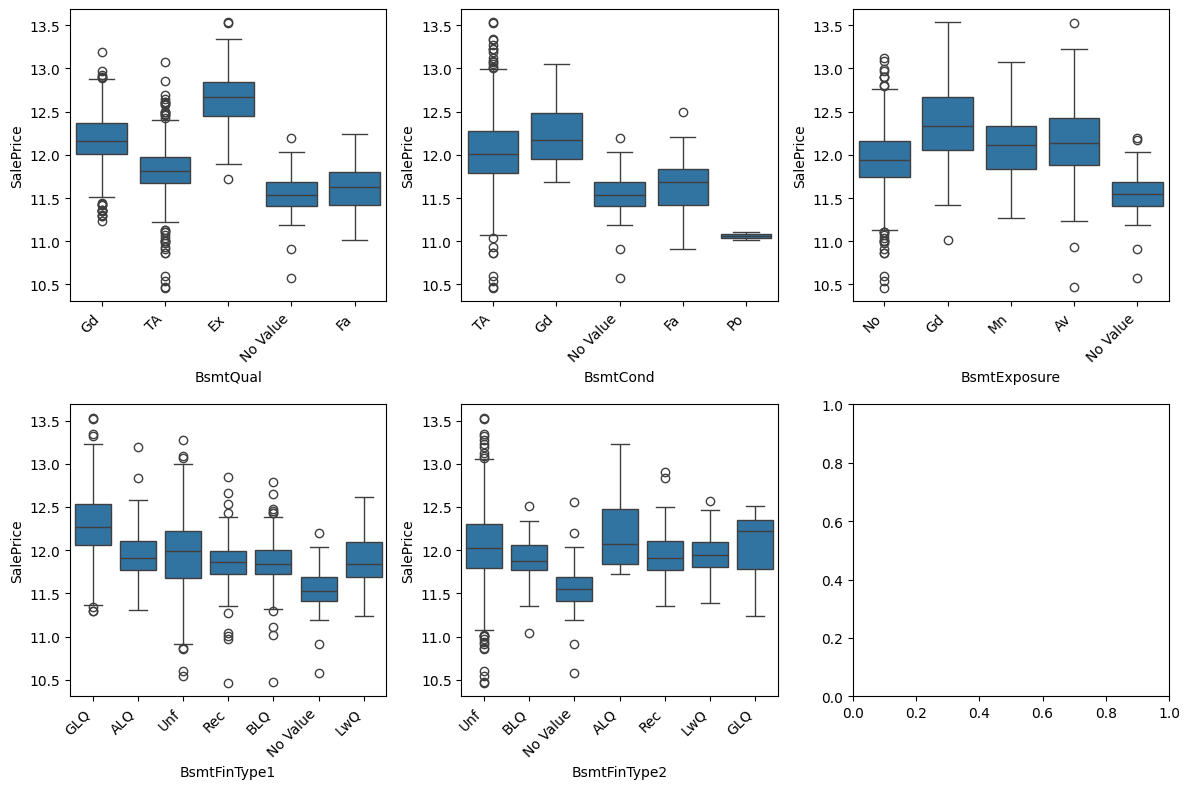

In [1429]:
#Boxplots for Basement_feat
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()
for i, col in enumerate(Basement_feat):
    sns.boxplot(x=col, y="SalePrice", data=train_df_cat, ax=axes[i])
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout() 
plt.show()

#In BsmtQual merge Fa and No value
#BsmtCond mergee Fa and No value
#BsmtExposure merge Mn and Av,No
#BsmtFinType1 merge Rec+Blq, ALQ+LWQ
# BsmtFinType2 merge BLQ+REC+LWQ



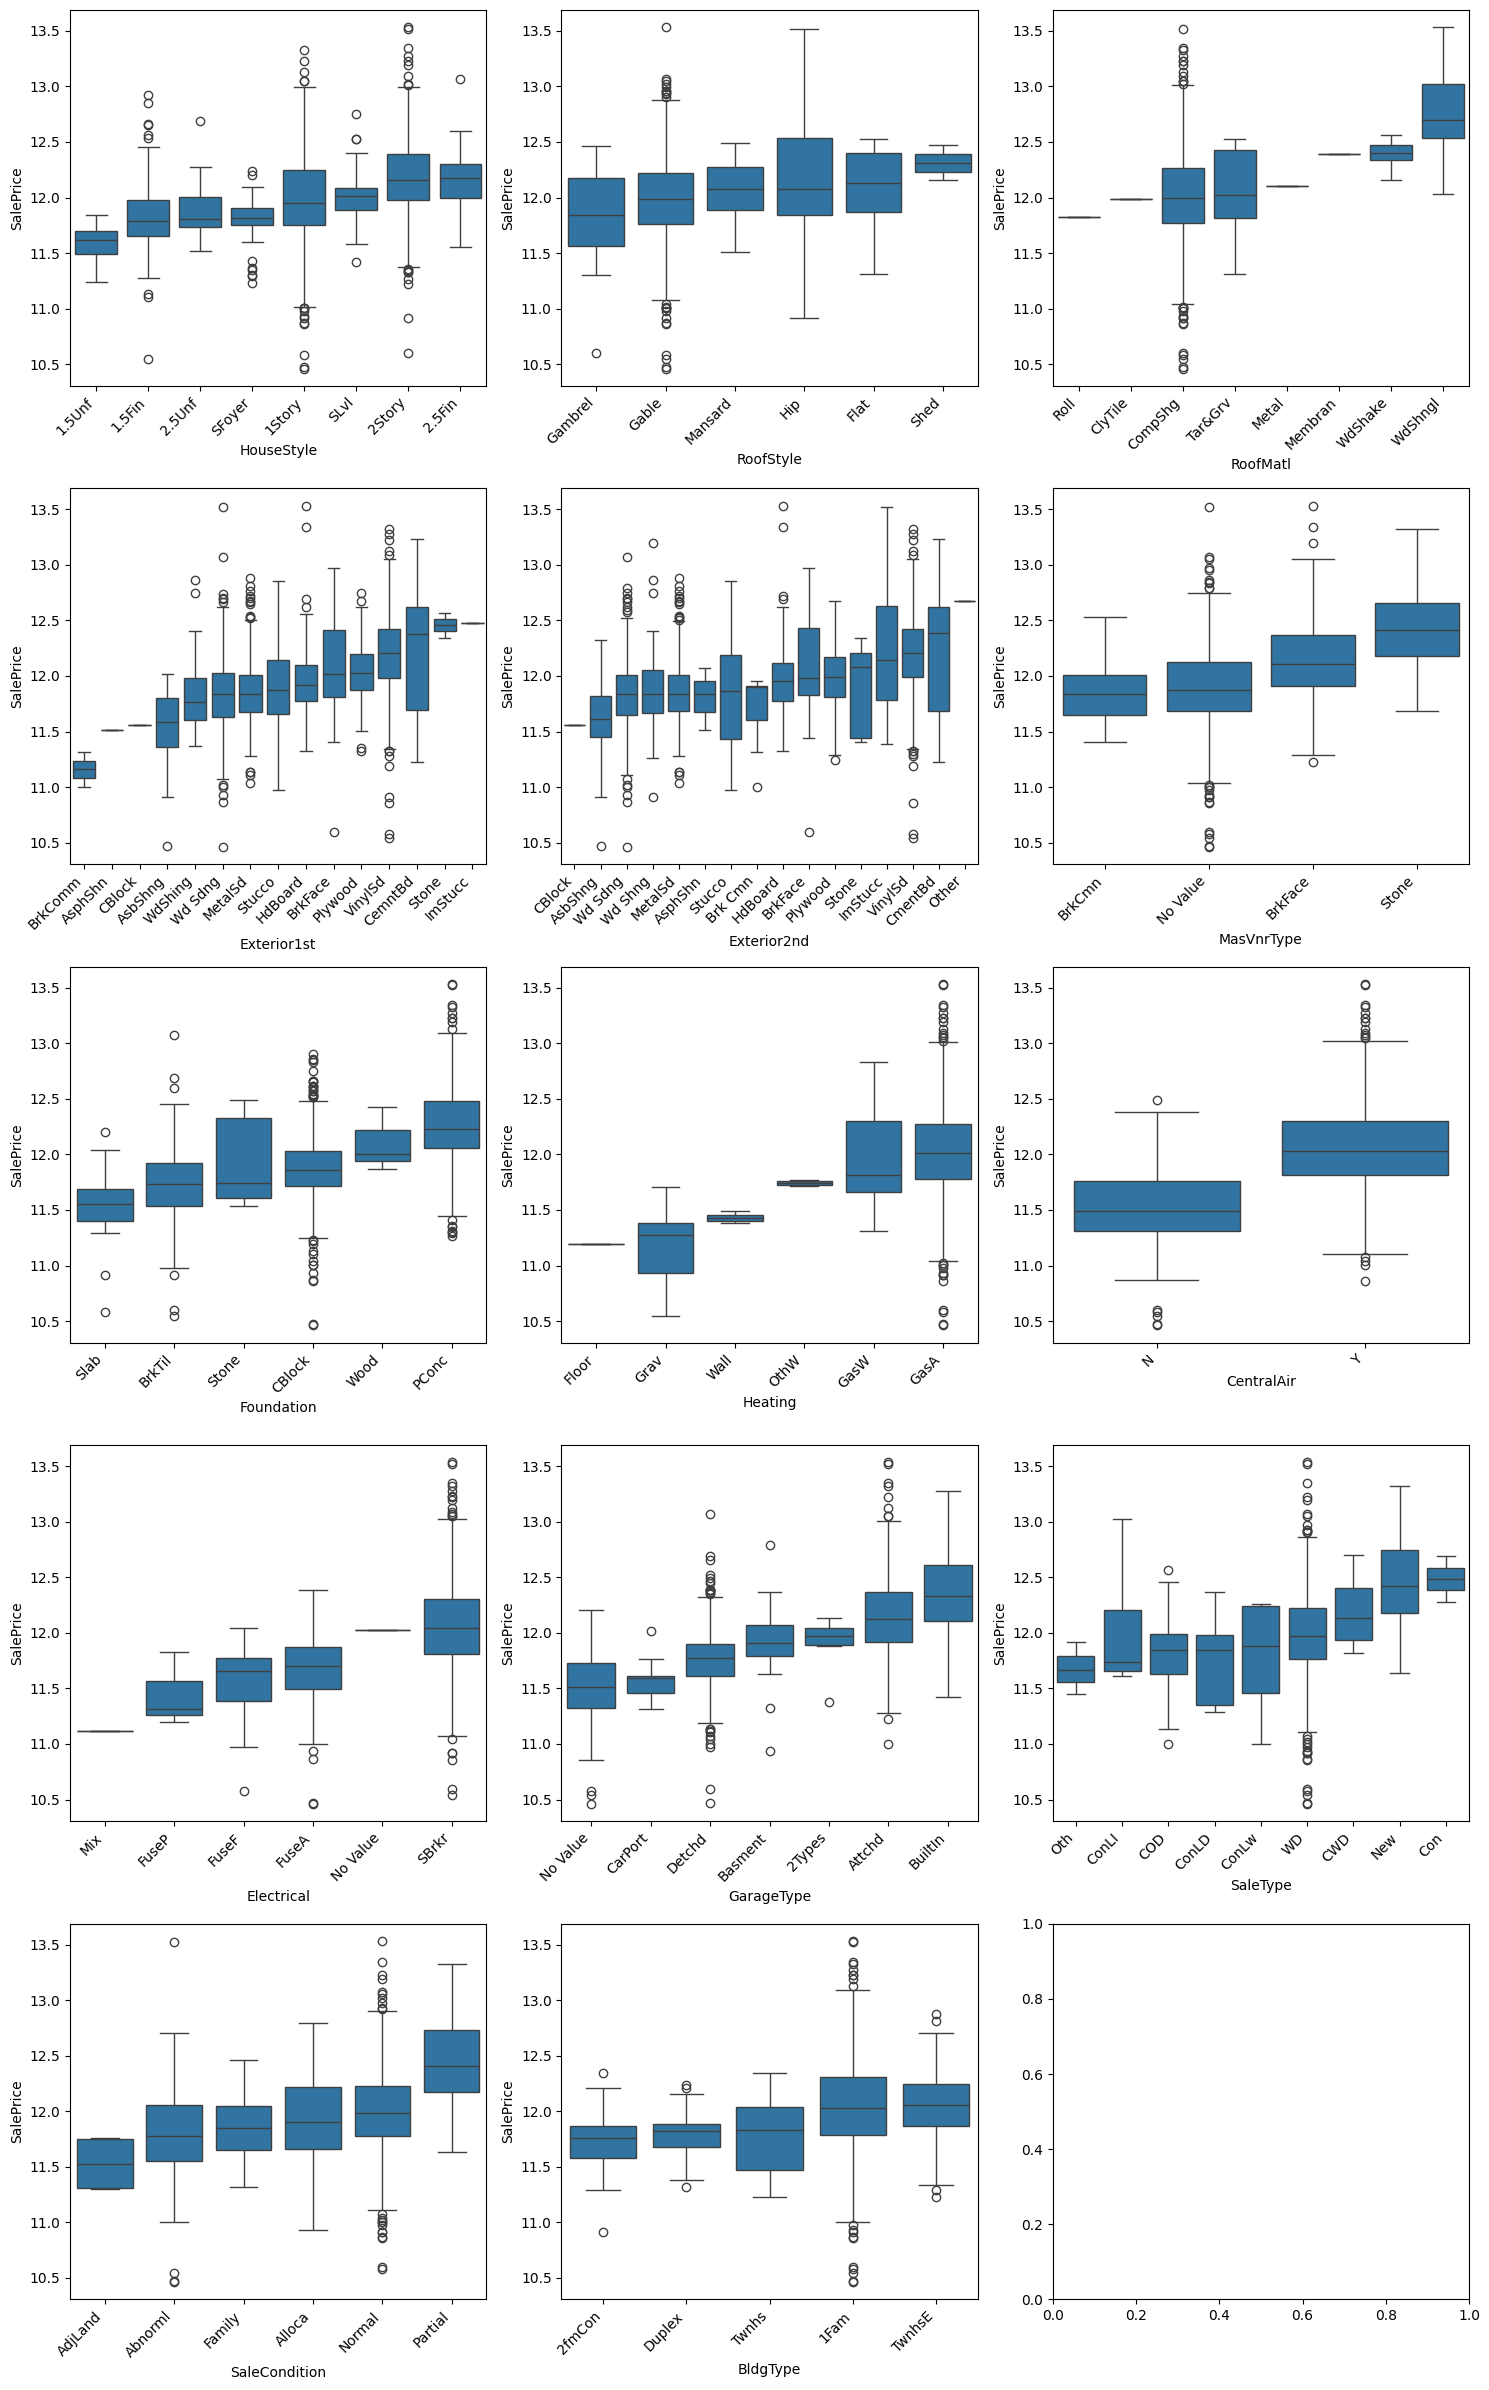

In [1430]:
#Boxplots for BaseBuilding_type_feat
fig, axes = plt.subplots(5, 3, figsize=(15, 24))
axes = axes.flatten()
for i, col in enumerate(Building_type_feat):
    order = train_df_cat.groupby(col)['SalePrice'].median().sort_values().index 
    sns.boxplot(x=col, y='SalePrice', data=train_df_cat, ax=axes[i], order=order)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout() 
plt.show()

#HouseStyle:Combine 1.5Fin+2.5Unf+SFoyer and 1Story+SLvL and 2Story+2.5Fin
#RoofStyle: Gable+Mansard+Hip+Flat
#RoofMatl: Merge Roll+CityTile+CompShg and Tar&Grv+Metal and Membran+WdShake and WdShngl
#Exterior1st: Merge AsphShn+CBlock+AsbShng and Wd Sdng+MetalSd and Stucco+HdBoard and BrkFace+Plywood and Stone+ImStucc
#Exterior2nd:CbBlock+AsbShng and Wd Sdng+Wd Shng+MetalSd+AsphShn+Stucco+Brk Cmn and HdBoard+BrkFace+Plywood and IamStucc+VinylSd and CmentBd+Other
#MasVnrType:BrkCmn+No Value
#Foundation: BrkTil+Stone
#Heating: Floor+Grav+Wall and OthW+GasW
#Eletrical: Mix+FuseP and FuseF+FuseA and SBrkr+No Value
#GarageType: Basement+2Types
#SaleType: COD+ConLD+ConLW
#SaleCondition:Abnorml+Family+Alloca
#BldgType: 2fmCon+Duplex+Twnhs and 1Fam+TwnhsE



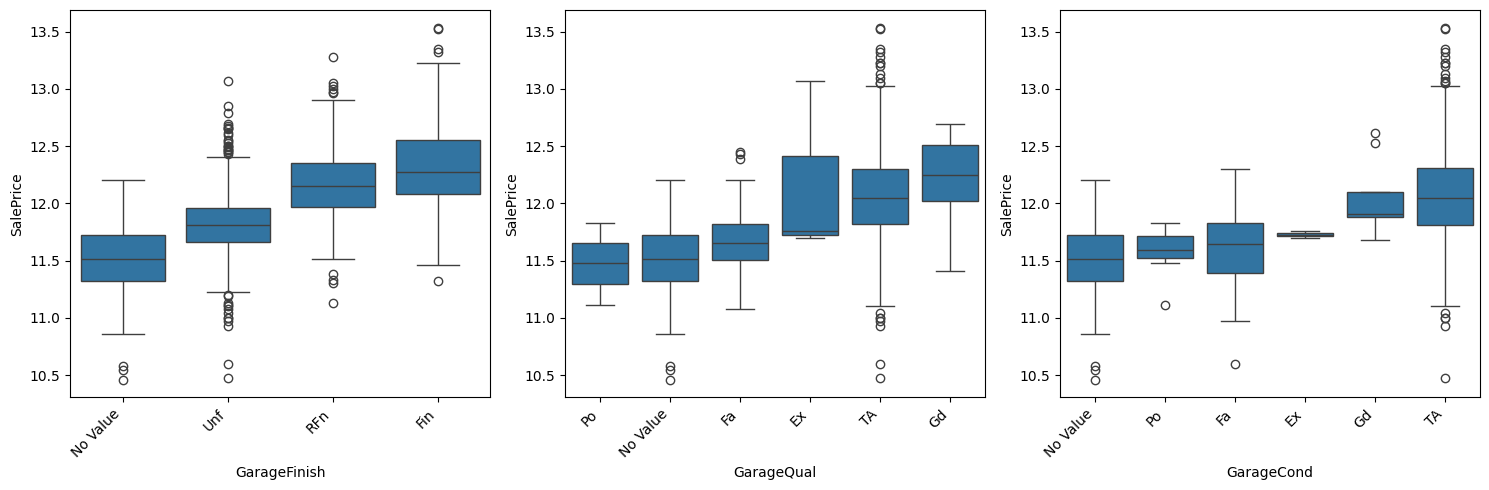

In [1431]:
#Boxplots for Garage_feat
fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes = axes.flatten()
for i, col in enumerate(Garage_feat):
    order = train_df_cat.groupby(col)['SalePrice'].median().sort_values().index 
    sns.boxplot(x=col, y='SalePrice', data=train_df_cat, ax=axes[i], order=order)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout() 
plt.show()

#GarageFinish: RFn+Fin
#GarageQual: Po+No Value
#GarageCond: No Value+Po+Fa+Ex

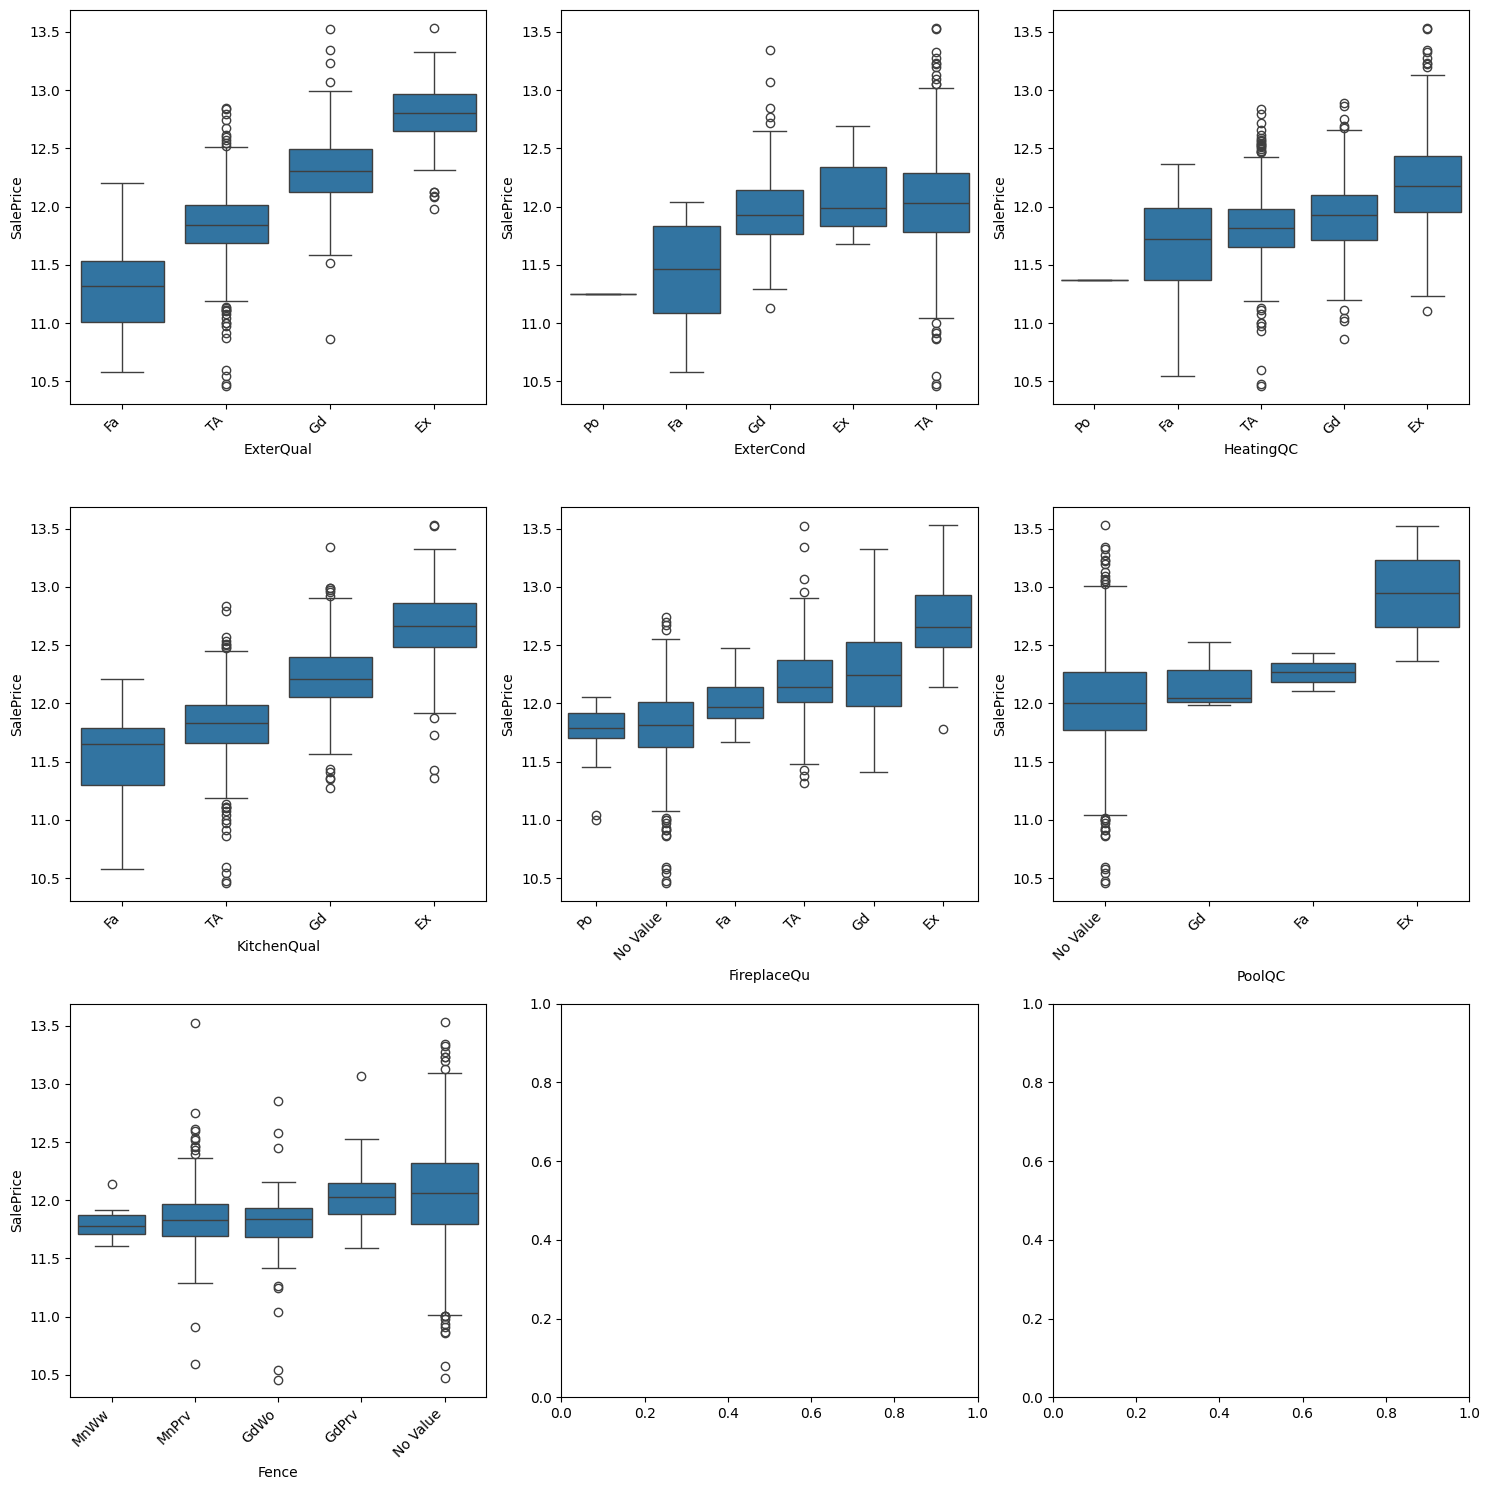

In [1432]:
#Boxplots for Quality_feat
fig, axes = plt.subplots(3, 3, figsize=(15,15))
axes = axes.flatten()
for i, col in enumerate(Quality_feat):
    order = train_df_cat.groupby(col)['SalePrice'].median().sort_values().index 
    sns.boxplot(x=col, y='SalePrice', data=train_df_cat, ax=axes[i], order=order)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout() 
plt.show()

#ExterCond:- Po+Fa and Ex+TA
#HeatingQC: Po+Fa+TA
#FireplaceQu: Po+No Value and TA_Gd
#PoolQA: No Value+Fa+Gd
#Fence: MnWw+MnPrv+GdWo and GdPrv+No Value


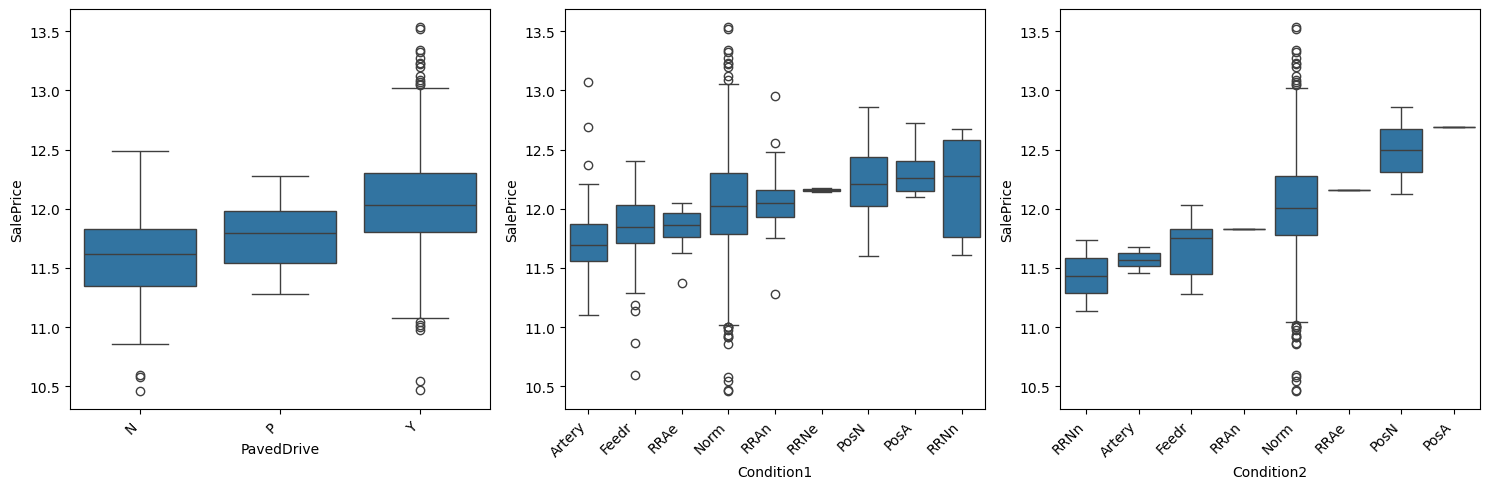

In [1433]:
#Boxplots for Condition_feat
fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes = axes.flatten()
for i, col in enumerate(Condition_feat):
    order = train_df_cat.groupby(col)['SalePrice'].median().sort_values().index 
    sns.boxplot(x=col, y='SalePrice', data=train_df_cat, ax=axes[i], order=order)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout() 
plt.show()

#Condition1: Feedr+RRAe and Norm+RRAn+RRNe and PosN+PosA+RRNn
#Condition2:Feedr+RRAn and Norm+RRAe and PosN+PosA


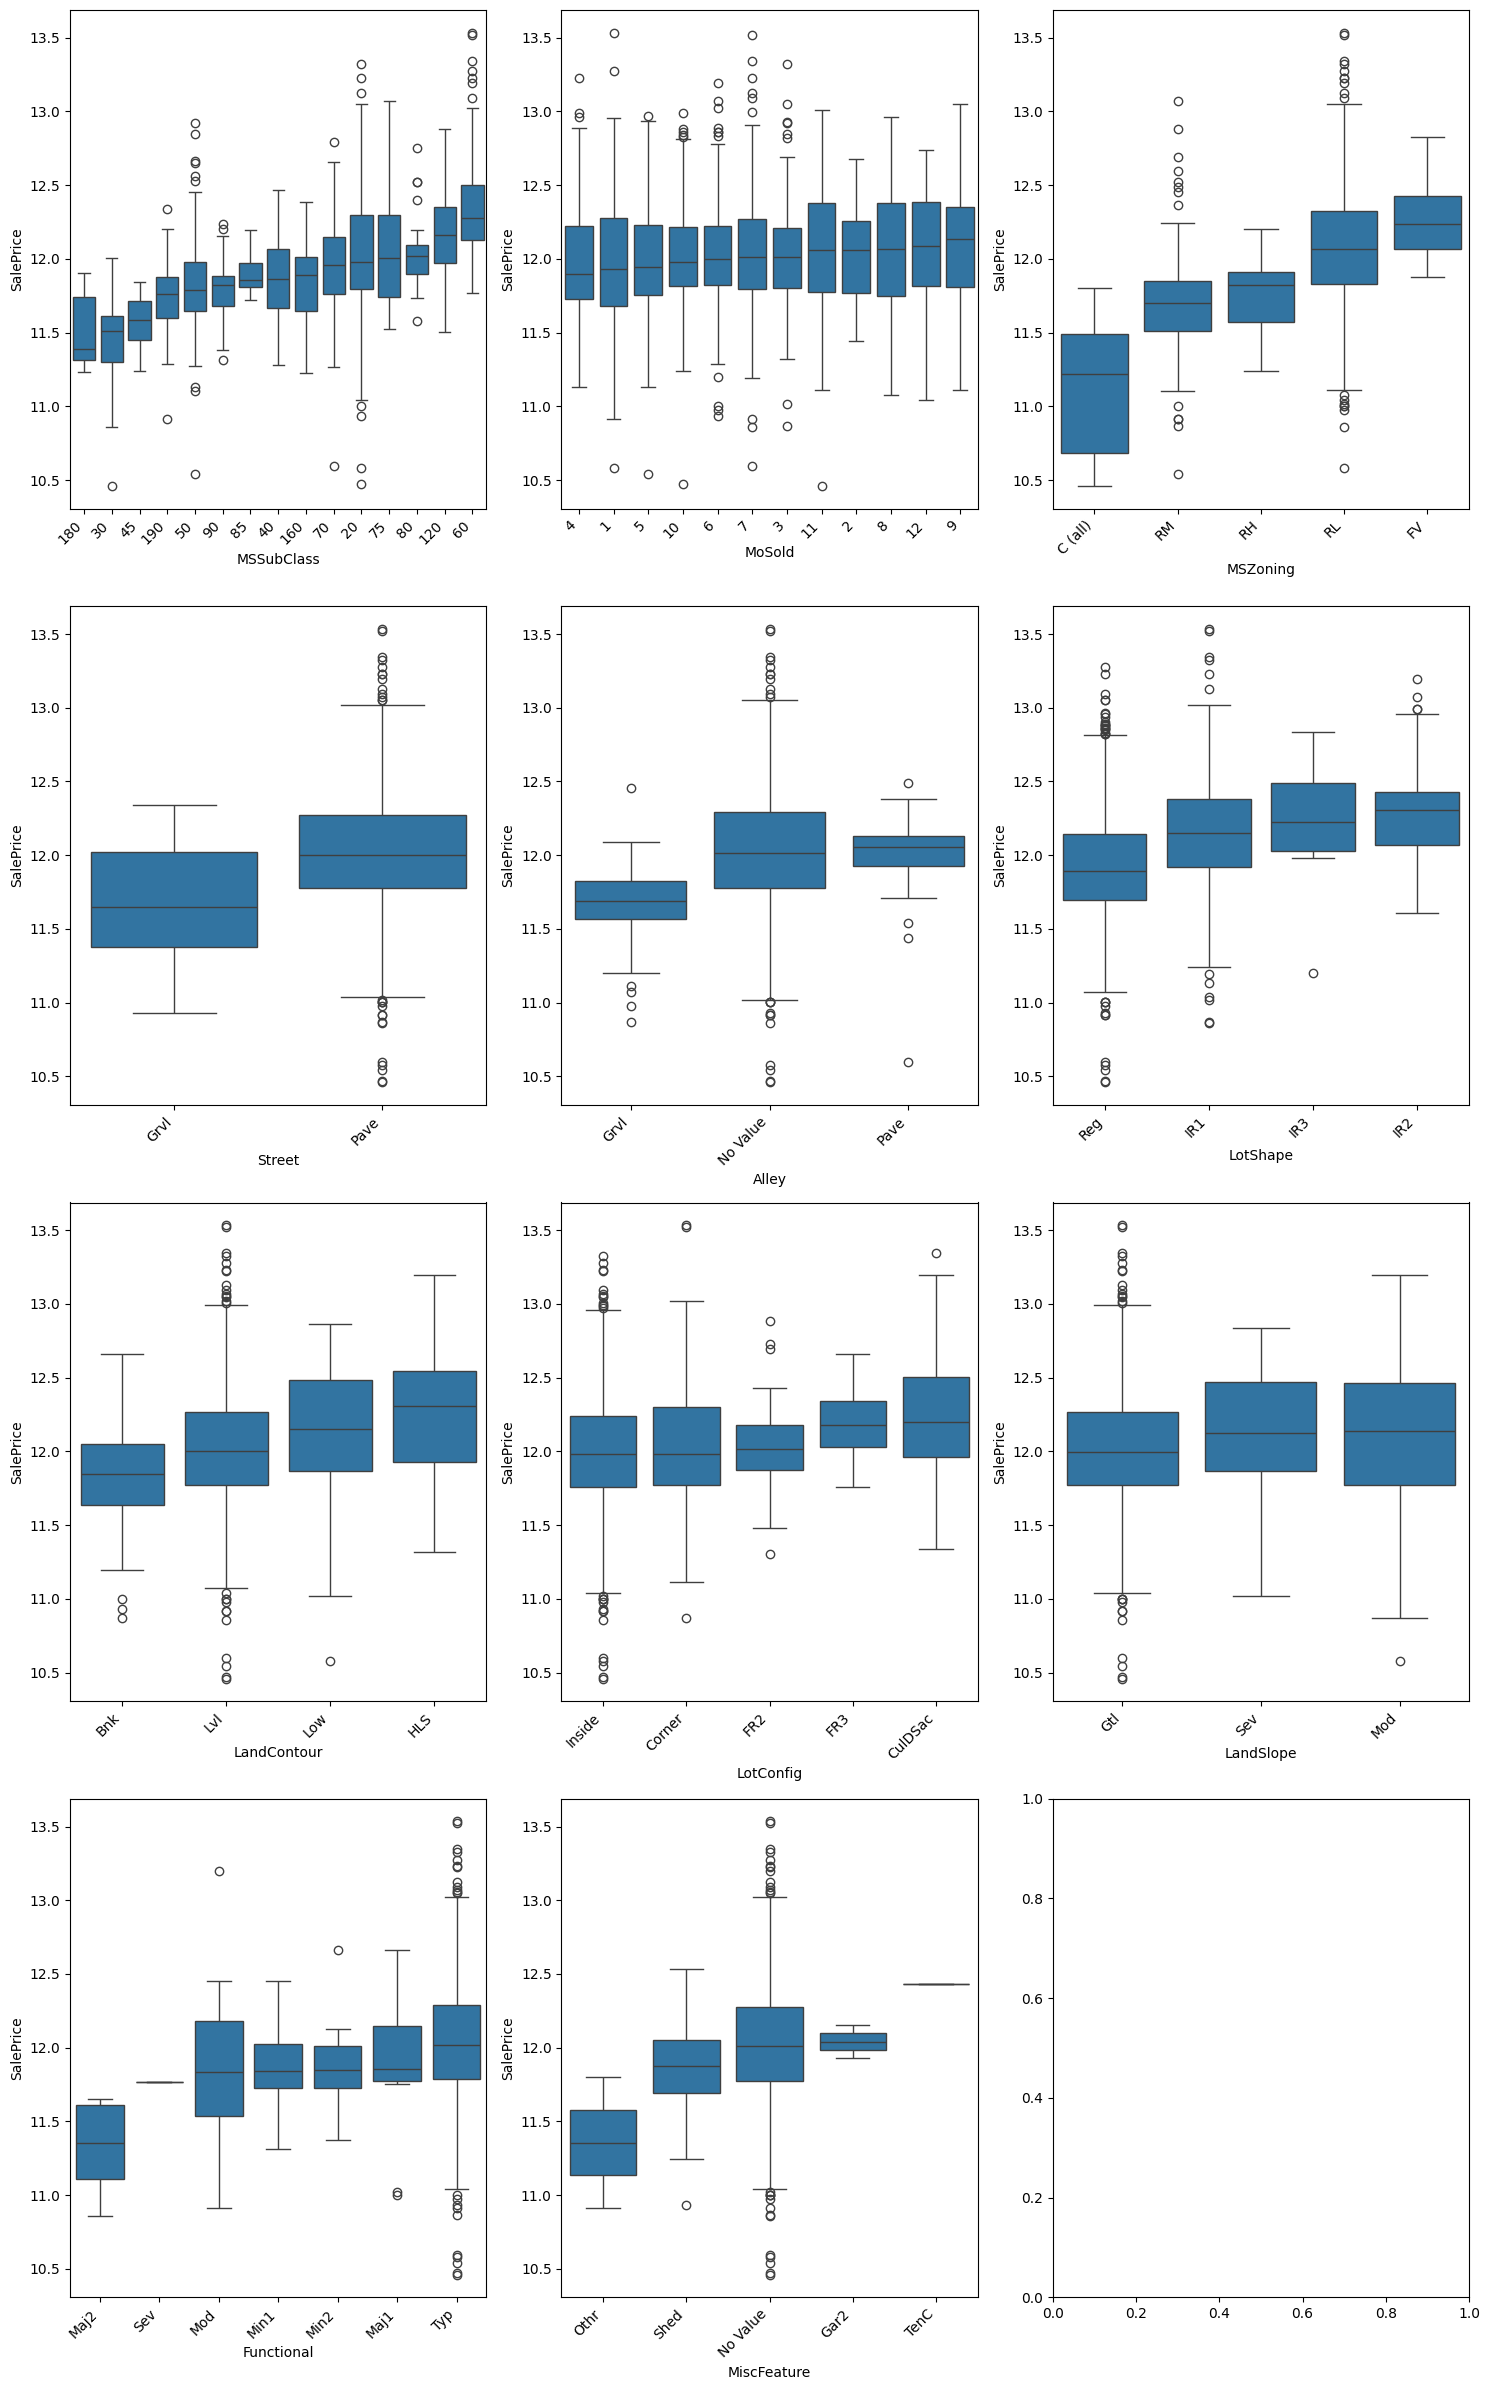

In [1434]:
#Boxplots for House_feat
fig, axes = plt.subplots(4, 3, figsize=(15,24))
axes = axes.flatten()
for i, col in enumerate(House_feat):
    order = train_df_cat.groupby(col)['SalePrice'].median().sort_values().index 
    sns.boxplot(x=col, y='SalePrice', data=train_df_cat, ax=axes[i], order=order)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout() 
plt.show()

#MSSubClass: 190+50+90 and 85+40+160 and 70+20+75+80
#MoSold: Delete it 
#Alley: No Value+Pave
#LotShape: IR1+IR3
#LotConfig:- Inside+Corner+FR2 and FR3+CulDSac
#LandSlope: Sev+Mod
#Functional: Sev+Mod+Min1+Min2+Maj1
#MiscFeature: No Value+Gar2


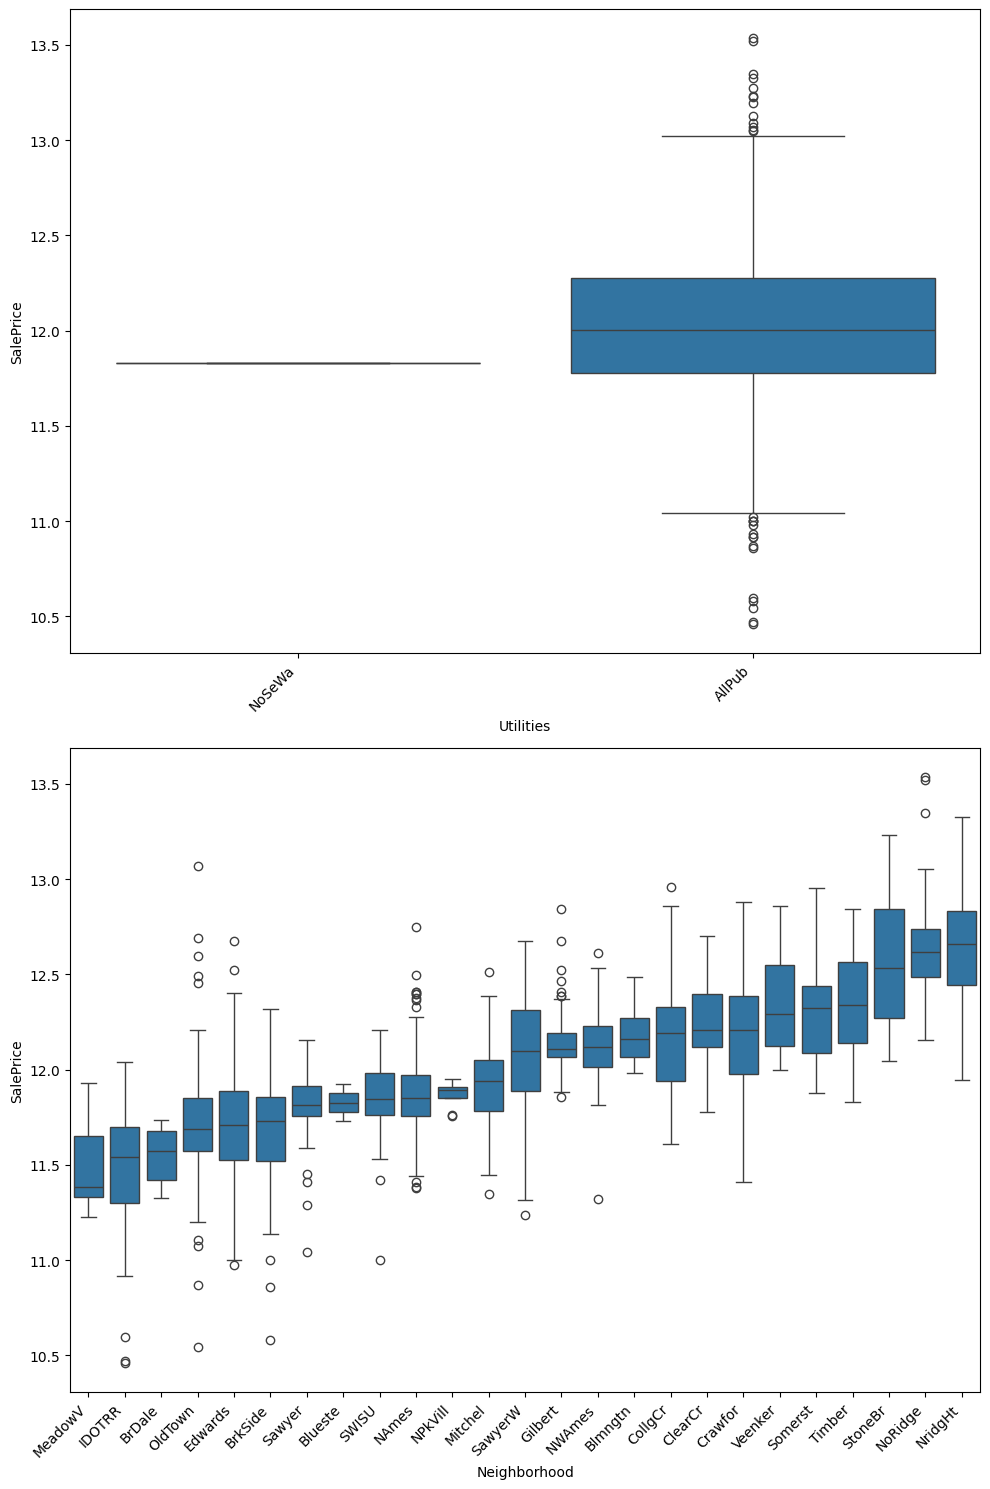

In [1435]:
#Boxplots for Utilies_feat
fig, axes = plt.subplots(2, 1, figsize=(10,15))
axes = axes.flatten()
for i, col in enumerate(Utilies_feat):
    order = train_df_cat.groupby(col)['SalePrice'].median().sort_values().index 
    sns.boxplot(x=col, y='SalePrice', data=train_df_cat, ax=axes[i], order=order)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout() 
plt.show()
#Utilies: Delete
#Neighborhood: IDOTRR+BrDale and OldTown+Edwards+BrkSide and Sawyer+Blueste+SWISU+NAmes+NPKVill and SawyerW+Gilbert+NWAmes and Blmngtn+CollgCr+ClearCr+Crawfor and Somerst+Timber and NoRidge+NridgHt

In [1436]:
#Action items for Categorical features
#In BsmtQual merge Fa and No value
#BsmtCond mergee Fa and No value
#BsmtExposure merge Mn and Av,No
#BsmtFinType1 merge Rec+Blq, ALQ+LWQ
#BsmtFinType2 merge BLQ+REC+LWQ
#HouseStyle:Combine 1.5Fin+2.5Unf+SFoyer and 1Story+SLvL and 2Story+2.5Fin
#RoofStyle: Gable+Mansard+Hip+Flat
#RoofMatl: Merge Roll+CityTile+CompShg and Tar&Grv+Metal and Membran+WdShake and WdShngl
#Exterior1st: Merge AsphShn+CBlock+AsbShng and Wd Sdng+MetalSd and Stucco+HdBoard and BrkFace+Plywood and Stone+ImStucc
#Exterior2nd:CbBlock+AsbShng and Wd Sdng+Wd Shng+MetalSd+AsphShn+Stucco+Brk Cmn and HdBoard+BrkFace+Plywood and IamStucc+VinylSd and CmentBd+Other
#MasVnrType:BrkCmn+No Value
#Foundation: BrkTil+Stone
#Heating: Floor+Grav+Wall and OthW+GasW
#Eletrical: Mix+FuseP and FuseF+FuseA and SBrkr+No Value
#GarageType: Basement+2Types
#SaleType: COD+ConLD+ConLW
#SaleCondition:Abnorml+Family+Alloca
#BldgType: 2fmCon+Duplex+Twnhs and 1Fam+TwnhsE
#GarageFinish: RFn+Fin
#GarageQual: Po+No Value
#GarageCond: No Value+Po+Fa+Ex
#ExterCond:- Po+Fa and Ex+TA
#HeatingQC: Po+Fa+TA
#FireplaceQu: Po+No Value and TA_Gd
#PoolQA: No Value+Fa+Gd
#Fence: MnWw+MnPrv+GdWo and GdPrv+No Value
#Condition1: Feedr+RRAe and Norm+RRAn+RRNe and PosN+PosA+RRNn
#Condition2:Feedr+RRAn and Norm+RRAe and PosN+PosA
#MSSubClass: 190+50+90 and 85+40+160 and 70+20+75+80
#MoSold: Delete it 
#Alley: No Value+Pave
#LotShape: IR1+IR3
#LotConfig:- Inside+Corner+FR2 and FR3+CulDSac
#LandSlope: Sev+Mod
#Functional: Sev+Mod+Min1+Min2+Maj1
#MiscFeature: No Value+Gar2
#Utilies: Delete
#Neighborhood: IDOTRR+BrDale and OldTown+Edwards+BrkSide and Sawyer+Blueste+SWISU+NAmes+NPKVill and SawyerW+Gilbert+NWAmes and Blmngtn+CollgCr+ClearCr+Crawfor and Somerst+Timber and NoRidge+NridgHt
# train_df_cat=train_df_cat[train_df_cat['SalePrice']<=13.25]
# print(train_df_cat.shape)
# train_df_cat=train_df_cat[train_df_cat['SalePrice']>=11]
# print(train_df_cat.shape)

In [1437]:
Before_merge_Unique_counts=0
Cat_cols=[col for col in train_df_cat.columns]
Cat_cols.remove('SalePrice')
for col in Cat_cols:
    Before_merge_Unique_counts+=train_df_cat[col].nunique()
    # print(col,Unique_counts)

print('Before merge:',Before_merge_Unique_counts)

Before merge: 294


In [1438]:
#BsmtQual
print("Before merge in train:",(train_df_cat['BsmtQual'].unique()))
BsmtQual_merge={'Fa':'Fa_Nov','No Value':'Fa_Nov'}
train_df_cat['BsmtQual']=train_df_cat['BsmtQual'].replace(BsmtQual_merge)
print("After merge in train :",(train_df_cat['BsmtQual'].unique()))

print("Before merge in test:",(test_df_cat['BsmtQual'].unique()))
BsmtQual_merge={'Fa':'Fa_Nov','No Value':'Fa_Nov'}
test_df_cat['BsmtQual']=test_df_cat['BsmtQual'].replace(BsmtQual_merge)
print("After merge in test :",(test_df_cat['BsmtQual'].unique()))


Before merge in train: ['Gd' 'TA' 'Ex' 'No Value' 'Fa']
After merge in train : ['Gd' 'TA' 'Ex' 'Fa_Nov']
Before merge in test: ['TA' 'Gd' 'Ex' 'Fa' 'No Value']
After merge in test : ['TA' 'Gd' 'Ex' 'Fa_Nov']


In [1439]:
#BsmtCond
print("Before merge in train:",(train_df_cat['BsmtCond'].unique()))
BsmtCond_merge={'Fa':'Fa_Nov','No Value':'Fa_Nov'}
train_df_cat['BsmtCond']=train_df_cat['BsmtCond'].replace(BsmtCond_merge)
print("After merge in train:",(train_df_cat['BsmtQual'].unique()))

print("Before merge in test:",(test_df_cat['BsmtCond'].unique()))
BsmtCond_merge={'Fa':'Fa_Nov','No Value':'Fa_Nov'}
test_df_cat['BsmtCond']=test_df_cat['BsmtCond'].replace(BsmtCond_merge)
print("After merge in test:",(test_df_cat['BsmtCond'].unique()))

Before merge in train: ['TA' 'Gd' 'No Value' 'Fa' 'Po']
After merge in train: ['Gd' 'TA' 'Ex' 'Fa_Nov']
Before merge in test: ['TA' 'Po' 'Fa' 'Gd' 'No Value']
After merge in test: ['TA' 'Po' 'Fa_Nov' 'Gd']


In [1440]:
#BsmtExposure merge Mn and Av
print("Before merge:",(train_df_cat['BsmtExposure'].unique()))
BsmtExposure_merge={'Mn':'Mn_Av','Av':'Mn_Av'}
train_df_cat['BsmtExposure']=train_df_cat['BsmtExposure'].replace(BsmtExposure_merge)
print("After merge:",(train_df_cat['BsmtExposure'].unique()))

print("Before merge in test:",(test_df_cat['BsmtExposure'].unique()))
BsmtExposure_merge={'Mn':'Mn_Av','Av':'Mn_Av'}
test_df_cat['BsmtExposure']=test_df_cat['BsmtExposure'].replace(BsmtExposure_merge)
print("After merge in test:",(test_df_cat['BsmtExposure'].unique()))

Before merge: ['No' 'Gd' 'Mn' 'Av' 'No Value']
After merge: ['No' 'Gd' 'Mn_Av' 'No Value']
Before merge in test: ['No' 'Gd' 'Mn' 'Av' 'No Value']
After merge in test: ['No' 'Gd' 'Mn_Av' 'No Value']


In [1441]:
#BsmtFinType1 merge Rec+Blq, ALQ+LWQ
print("Before merge:",(train_df_cat['BsmtFinType1'].unique()))
BsmtFinType1_merge={'Rec':'Rec_Blq','BLQ':'Rec_Blq','ALQ':'ALQ_LWQ','LwQ':'ALQ_LWQ'}
train_df_cat['BsmtFinType1']=train_df_cat['BsmtFinType1'].replace(BsmtFinType1_merge)
print("After merge:",(train_df_cat['BsmtFinType1'].unique()))

print("Before merge in test:",(test_df_cat['BsmtFinType1'].unique()))
BsmtFinType1_merge={'Rec':'Rec_Blq','BLQ':'Rec_Blq','ALQ':'ALQ_LWQ','LwQ':'ALQ_LWQ'}
test_df_cat['BsmtFinType1']=test_df_cat['BsmtFinType1'].replace(BsmtFinType1_merge)
print("After merge in test:",(test_df_cat['BsmtFinType1'].unique()))

Before merge: ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'No Value' 'LwQ']
After merge: ['GLQ' 'ALQ_LWQ' 'Unf' 'Rec_Blq' 'No Value']
Before merge in test: ['Rec' 'ALQ' 'GLQ' 'Unf' 'BLQ' 'LwQ' 'No Value']
After merge in test: ['Rec_Blq' 'ALQ_LWQ' 'GLQ' 'Unf' 'No Value']


In [1442]:
#BsmtFinType2 merge BLQ+REC+LWQ
print("Before merge:",(train_df_cat['BsmtFinType2'].unique()))
BsmtFinType2_merge={'BLQ':'BLQ_REC_LWQ','Rec':'BLQ_REC_LWQ','LwQ':'BLQ_REC_LWQ'}
train_df_cat['BsmtFinType2']=train_df_cat['BsmtFinType2'].replace(BsmtFinType2_merge)
print("After merge:",(train_df_cat['BsmtFinType2'].unique()))   

print("Before merge in test:",(test_df_cat['BsmtFinType2'].unique()))
BsmtFinType2_merge={'BLQ':'BLQ_REC_LWQ','Rec':'BLQ_REC_LWQ','LwQ':'BLQ_REC_LWQ'}
test_df_cat['BsmtFinType2']=test_df_cat['BsmtFinType2'].replace(BsmtFinType2_merge)
print("After merge in test:",(test_df_cat['BsmtFinType2'].unique()))

Before merge: ['Unf' 'BLQ' 'No Value' 'ALQ' 'Rec' 'LwQ' 'GLQ']
After merge: ['Unf' 'BLQ_REC_LWQ' 'No Value' 'ALQ' 'GLQ']
Before merge in test: ['LwQ' 'Unf' 'Rec' 'BLQ' 'GLQ' 'ALQ' 'No Value']
After merge in test: ['BLQ_REC_LWQ' 'Unf' 'GLQ' 'ALQ' 'No Value']


In [1443]:
#HouseStyle:Combine 1.5Fin+2.5Unf+SFoyer and 1Story+SLvL and 2Story+2.5Fin
print("Before merge:",(train_df_cat['HouseStyle'].unique()))
HouseStyle_merge={'1.5Fin':'1.5Fin_2.5Unf_SFoyer','2.5Unf':'1.5Fin_2.5Unf_SFoyer','SFoyer':'1.5Fin_2.5Unf_SFoyer',\
                  '1Story':'1Story+SLvL','SLvl':'1Story+SLvL','2Story':'2Story+2.5Fin','2.5Fin':'2Story+2.5Fin'}
train_df_cat['HouseStyle']=train_df_cat['HouseStyle'].replace(HouseStyle_merge)
print("After merge:",(train_df_cat['HouseStyle'].unique()))

print("Before merge in test:",(test_df_cat['HouseStyle'].unique()))
HouseStyle_merge={'1.5Fin':'1.5Fin_2.5Unf_SFoyer','2.5Unf':'1.5Fin_2.5Unf_SFoyer','SFoyer':'1.5Fin_2.5Unf_SFoyer',\
                  '1Story':'1Story+SLvL','SLvl':'1Story+SLvL','2Story':'2Story+2.5Fin','2.5Fin':'2Story+2.5Fin'}
test_df_cat['HouseStyle']=test_df_cat['HouseStyle'].replace(HouseStyle_merge)
print("After merge in test:",(test_df_cat['HouseStyle'].unique()))

Before merge: ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
After merge: ['2Story+2.5Fin' '1Story+SLvL' '1.5Fin_2.5Unf_SFoyer' '1.5Unf']
Before merge in test: ['1Story' '2Story' 'SLvl' '1.5Fin' 'SFoyer' '2.5Unf' '1.5Unf']
After merge in test: ['1Story+SLvL' '2Story+2.5Fin' '1.5Fin_2.5Unf_SFoyer' '1.5Unf']


In [1444]:
#RoofStyle: Gable+Mansard+Hip+Flat
print("Before merge:",(train_df_cat['RoofStyle'].unique()))
RoofStyle_merge={'Gable':'Gable_Mansard_Hip_Flat','Mansard':'Gable_Mansard_Hip_Flat','Hip':'Gable_Mansard_Hip_Flat','Flat':'Gable_Mansard_Hip_Flat'}
train_df_cat['RoofStyle']=train_df_cat['RoofStyle'].replace(RoofStyle_merge)
print("After merge:",(train_df_cat['RoofStyle'].unique()))

print("Before merge in test:",(test_df_cat['RoofStyle'].unique()))
RoofStyle_merge={'Gable':'Gable_Mansard_Hip_Flat','Mansard':'Gable_Mansard_Hip_Flat','Hip':'Gable_Mansard_Hip_Flat','Flat':'Gable_Mansard_Hip_Flat'}
test_df_cat['RoofStyle']=test_df_cat['RoofStyle'].replace(RoofStyle_merge)
print("After merge in test:",(test_df_cat['RoofStyle'].unique()))

Before merge: ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
After merge: ['Gable_Mansard_Hip_Flat' 'Gambrel' 'Shed']
Before merge in test: ['Gable' 'Hip' 'Gambrel' 'Flat' 'Mansard' 'Shed']
After merge in test: ['Gable_Mansard_Hip_Flat' 'Gambrel' 'Shed']


In [1445]:
#RoofMatl: Merge Roll+ClyTile+CompShg and Tar&Grv+Metal and Membran+WdShake and WdShngl
print("Before merge:",(train_df_cat['RoofMatl'].unique()))
RoofMatl_merge={'Roll':'Roll_ClyTile_CompShg','ClyTile':'Roll_ClyTile_CompShg','CompShg':'Roll_ClyTile_CompShg',\
                'Tar&Grv':'Tar&Grv_Metal','Metal':'Tar&Grv_Metal','Membran':'Membran_WdShake','WdShake':'Membran_WdShake'}
train_df_cat['RoofMatl']=train_df_cat['RoofMatl'].replace(RoofMatl_merge)
print("After merge:",(train_df_cat['RoofMatl'].unique()))

print("Before merge in test:",(test_df_cat['RoofMatl'].unique()))
RoofMatl_merge={'Roll':'Roll_ClyTile_CompShg','ClyTile':'Roll_ClyTile_CompShg','CompShg':'Roll_ClyTile_CompShg',\
                'Tar&Grv':'Tar&Grv_Metal','Metal':'Tar&Grv_Metal','Membran':'Membran_WdShake','WdShake':'Membran_WdShake'}
test_df_cat['RoofMatl']=test_df_cat['RoofMatl'].replace(RoofMatl_merge)
print("After merge in test:",(test_df_cat['RoofMatl'].unique()))

Before merge: ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'
 'ClyTile']
After merge: ['Roll_ClyTile_CompShg' 'WdShngl' 'Tar&Grv_Metal' 'Membran_WdShake']
Before merge in test: ['CompShg' 'Tar&Grv' 'WdShake' 'WdShngl']
After merge in test: ['Roll_ClyTile_CompShg' 'Tar&Grv_Metal' 'Membran_WdShake' 'WdShngl']


In [1446]:
#Exterior1st: Merge AsphShn+CBlock+AsbShng and Wd Sdng+MetalSd and Stucco+HdBoard and BrkFace+Plywood and Stone+ImStucc
print("Before merge:",(train_df_cat['Exterior1st'].unique()))
Exterior1st_merge={'AsphShn':'AsphShn_CBlock_AsbShng','CBlock':'AsphShn_CBlock_AsbShng','AsbShng':'AsphShn_CBlock_AsbShng',\
                   'Wd Sdng':'Wd Sdng_MetalSd','MetalSd':'Wd Sdng_MetalSd','Stucco':'Stucco_HdBoard','HdBoard':'Stucco_HdBoard',\
                   'BrkFace':'BrkFace_Plywood','Plywood':'BrkFace_Plywood','Stone':'Stone_ImStucc','ImStucc':'Stone_ImStucc'}
train_df_cat['Exterior1st']=train_df_cat['Exterior1st'].replace(Exterior1st_merge)
print("After merge:",(train_df_cat['Exterior1st'].unique()))

print("Before merge in test:",(test_df_cat['Exterior1st'].unique()))
Exterior1st_merge={'AsphShn':'AsphShn_CBlock_AsbShng','CBlock':'AsphShn_CBlock_AsbShng','AsbShng':'AsphShn_CBlock_AsbShng',\
                   'Wd Sdng':'Wd Sdng_MetalSd','MetalSd':'Wd Sdng_MetalSd','Stucco':'Stucco_HdBoard','HdBoard':'Stucco_HdBoard',\
                   'BrkFace':'BrkFace_Plywood','Plywood':'BrkFace_Plywood','Stone':'Stone_ImStucc','ImStucc':'Stone_ImStucc'}
test_df_cat['Exterior1st']=test_df_cat['Exterior1st'].replace(Exterior1st_merge)
print("After merge in test:",(test_df_cat['Exterior1st'].unique()))

Before merge: ['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace' 'WdShing' 'CemntBd'
 'Plywood' 'AsbShng' 'Stucco' 'BrkComm' 'AsphShn' 'Stone' 'ImStucc'
 'CBlock']
After merge: ['VinylSd' 'Wd Sdng_MetalSd' 'Stucco_HdBoard' 'BrkFace_Plywood' 'WdShing'
 'CemntBd' 'AsphShn_CBlock_AsbShng' 'BrkComm' 'Stone_ImStucc']
Before merge in test: ['VinylSd' 'Wd Sdng' 'HdBoard' 'Plywood' 'MetalSd' 'CemntBd' 'WdShing'
 'BrkFace' 'AsbShng' 'BrkComm' 'Stucco' 'AsphShn' 'No Value' 'CBlock']
After merge in test: ['VinylSd' 'Wd Sdng_MetalSd' 'Stucco_HdBoard' 'BrkFace_Plywood' 'CemntBd'
 'WdShing' 'AsphShn_CBlock_AsbShng' 'BrkComm' 'No Value']


In [1447]:
#Exterior2nd:CbBlock+AsbShng and Wd Sdng+Wd Shng+MetalSd+AsphShn+Stucco+Brk Cmn and HdBoard+BrkFace+Plywood and IamStucc+VinylSd and CmentBd+Other
print("Before merge:",(train_df_cat['Exterior2nd'].unique()))
Exterior2nd_merge={'CBlock':'CBlock_AsbShng','AsbShng':'CBlock_AsbShng','Wd Sdng':'Wd_Sdng_Wd_Shng_MetalSd_AsphShn_Stucco_Brk Cmn',\
                   'MetalSd':'Wd_Sdng_Wd_Shng_MetalSd_AsphShn_Stucco_Brk Cmn','Wd Shng':'Wd_Sdng_Wd_Shng_MetalSd_AsphShn_Stucco_Brk Cmn',\
                   'AsphShn':'Wd_Sdng_Wd_Shng_MetalSd_AsphShn_Stucco_Brk Cmn','Stucco':'Wd_Sdng_Wd_Shng_MetalSd_AsphShn_Stucco_Brk Cmn',\
                   'Brk Cmn':'Wd_Sdng_Wd_Shng_MetalSd_AsphShn_Stucco_Brk Cmn','HdBoard':'HdBoard_BrkFace_Plywood','BrkFace':'HdBoard_BrkFace_Plywood',\
                   'Plywood':'HdBoard_BrkFace_Plywood','ImStucc':'ImStucc_VinylSd','VinylSd':'ImStucc_VinylSd','CmentBd':'CmentBd_Other',\
                   'Other':'CmentBd_Other'}
train_df_cat['Exterior2nd']=train_df_cat['Exterior2nd'].replace(Exterior2nd_merge)
print("After merge:",(train_df_cat['Exterior2nd'].unique()))

print("Before merge in test:",(test_df_cat['Exterior2nd'].unique()))
Exterior2nd_merge={'CBlock':'CBlock_AsbShng','AsbShng':'CBlock_AsbShng','Wd Sdng':'Wd_Sdng_Wd_Shng_MetalSd_AsphShn_Stucco_Brk Cmn',\
                   'MetalSd':'Wd_Sdng_Wd_Shng_MetalSd_AsphShn_Stucco_Brk Cmn','Wd Shng':'Wd_Sdng_Wd_Shng_MetalSd_AsphShn_Stucco_Brk Cmn',\
                   'AsphShn':'Wd_Sdng_Wd_Shng_MetalSd_AsphShn_Stucco_Brk Cmn','Stucco':'Wd_Sdng_Wd_Shng_MetalSd_AsphShn_Stucco_Brk Cmn',\
                   'Brk Cmn':'Wd_Sdng_Wd_Shng_MetalSd_AsphShn_Stucco_Brk Cmn','HdBoard':'HdBoard_BrkFace_Plywood','BrkFace':'HdBoard_BrkFace_Plywood',\
                   'Plywood':'HdBoard_BrkFace_Plywood','ImStucc':'ImStucc_VinylSd','VinylSd':'ImStucc_VinylSd','CmentBd':'CmentBd_Other',\
                   'Other':'CmentBd_Other'}
test_df_cat['Exterior2nd']=test_df_cat['Exterior2nd'].replace(Exterior2nd_merge)
print("After merge in test:",(test_df_cat['Exterior2nd'].unique()))




                   


Before merge: ['VinylSd' 'MetalSd' 'Wd Shng' 'HdBoard' 'Plywood' 'Wd Sdng' 'CmentBd'
 'BrkFace' 'Stucco' 'AsbShng' 'Brk Cmn' 'ImStucc' 'AsphShn' 'Stone'
 'Other' 'CBlock']
After merge: ['ImStucc_VinylSd' 'Wd_Sdng_Wd_Shng_MetalSd_AsphShn_Stucco_Brk Cmn'
 'HdBoard_BrkFace_Plywood' 'CmentBd_Other' 'CBlock_AsbShng' 'Stone']
Before merge in test: ['VinylSd' 'Wd Sdng' 'HdBoard' 'Plywood' 'MetalSd' 'Brk Cmn' 'CmentBd'
 'ImStucc' 'Wd Shng' 'AsbShng' 'Stucco' 'CBlock' 'BrkFace' 'AsphShn'
 'No Value' 'Stone']
After merge in test: ['ImStucc_VinylSd' 'Wd_Sdng_Wd_Shng_MetalSd_AsphShn_Stucco_Brk Cmn'
 'HdBoard_BrkFace_Plywood' 'CmentBd_Other' 'CBlock_AsbShng' 'No Value'
 'Stone']


In [1448]:
#MasVnrType:BrkCmn+No Value
print("Before merge:",(train_df_cat['MasVnrType'].unique()))
MasVnrType_merge={'BrkCmn':'BrkCmn_No Value','No Value':'BrkCmn_No Value'}
train_df_cat['MasVnrType']=train_df_cat['MasVnrType'].replace(MasVnrType_merge)
print("After merge:",(train_df_cat['MasVnrType'].unique()))

print("Before merge in test:",(test_df_cat['MasVnrType'].unique()))
MasVnrType_merge={'BrkCmn':'BrkCmn_No Value','No Value':'BrkCmn_No Value'}
test_df_cat['MasVnrType']=test_df_cat['MasVnrType'].replace(MasVnrType_merge)
print("After merge in test:",(test_df_cat['MasVnrType'].unique()))



Before merge: ['BrkFace' 'No Value' 'Stone' 'BrkCmn']
After merge: ['BrkFace' 'BrkCmn_No Value' 'Stone']
Before merge in test: ['No Value' 'BrkFace' 'Stone' 'BrkCmn']
After merge in test: ['BrkCmn_No Value' 'BrkFace' 'Stone']


In [1449]:
#Foundation: BrkTil+Stone
print("Before merge:",(train_df_cat['Foundation'].unique()))
Foundation_merge={'BrkTil':'BrkTil_Stone','Stone':'BrkTil_Stone'}
train_df_cat['Foundation']=train_df_cat['Foundation'].replace(Foundation_merge)
print("After merge:",(train_df_cat['Foundation'].unique()))

print("Before merge in test:",(test_df_cat['Foundation'].unique()))
Foundation_merge={'BrkTil':'BrkTil_Stone','Stone':'BrkTil_Stone'}
test_df_cat['Foundation']=test_df_cat['Foundation'].replace(Foundation_merge)
print("After merge in test:",(test_df_cat['Foundation'].unique()))

Before merge: ['PConc' 'CBlock' 'BrkTil' 'Wood' 'Slab' 'Stone']
After merge: ['PConc' 'CBlock' 'BrkTil_Stone' 'Wood' 'Slab']
Before merge in test: ['CBlock' 'PConc' 'BrkTil' 'Stone' 'Slab' 'Wood']
After merge in test: ['CBlock' 'PConc' 'BrkTil_Stone' 'Slab' 'Wood']


In [1450]:
#Heating: Floor+Grav+Wall and OthW+GasW
print("Before merge:",(train_df_cat['Heating'].unique()))
Heating_merge={'Floor':'Floor_Grav_Wall','Grav':'Floor_Grav_Wall','Wall':'Floor_Grav_Wall','OthW':'OthW_GasW','GasW':'OthW_GasW'}
train_df_cat['Heating']=train_df_cat['Heating'].replace(Heating_merge)
print("After merge:",(train_df_cat['Heating'].unique()))

print("Before merge in test:",(test_df_cat['Heating'].unique()))
Heating_merge={'Floor':'Floor_Grav_Wall','Grav':'Floor_Grav_Wall','Wall':'Floor_Grav_Wall','OthW':'OthW_GasW','GasW':'OthW_GasW'}
test_df_cat['Heating']=test_df_cat['Heating'].replace(Heating_merge)
print("After merge in test:",(test_df_cat['Heating'].unique()))

Before merge: ['GasA' 'GasW' 'Grav' 'Wall' 'OthW' 'Floor']
After merge: ['GasA' 'OthW_GasW' 'Floor_Grav_Wall']
Before merge in test: ['GasA' 'GasW' 'Grav' 'Wall']
After merge in test: ['GasA' 'OthW_GasW' 'Floor_Grav_Wall']


In [1451]:
#Eletrical: Mix+FuseP and FuseF+FuseA and SBrkr+No Value
print("Before merge:",(train_df_cat['Electrical'].unique()))
Electrical_merge={'Mix':'Mix_FuseP','FuseP':'Mix_FuseP','FuseF':'FuseF_FuseA','FuseA':'FuseF_FuseA','SBrkr':'SBrkr_No Value','No Value':'SBrkr_No Value'}
train_df_cat['Electrical']=train_df_cat['Electrical'].replace(Electrical_merge)
print("After merge:",(train_df_cat['Electrical'].unique()))

print("Before merge in test:",(test_df_cat['Electrical'].unique()))
Electrical_merge={'Mix':'Mix_FuseP','FuseP':'Mix_FuseP','FuseF':'FuseF_FuseA','FuseA':'FuseF_FuseA','SBrkr':'SBrkr_No Value','No Value':'SBrkr_No Value'}
test_df_cat['Electrical']=test_df_cat['Electrical'].replace(Electrical_merge)
print("After merge in test:",(test_df_cat['Electrical'].unique()))

Before merge: ['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' 'No Value']
After merge: ['SBrkr_No Value' 'FuseF_FuseA' 'Mix_FuseP']
Before merge in test: ['SBrkr' 'FuseA' 'FuseF' 'FuseP']
After merge in test: ['SBrkr_No Value' 'FuseF_FuseA' 'Mix_FuseP']


In [1452]:
#GarageType: Basement+2Types
print("Before merge:",(train_df_cat['GarageType'].unique()))
GarageType_merge={'Basment':'Basment_2Types','2Types':'Basment_2Types'}
train_df_cat['GarageType']=train_df_cat['GarageType'].replace(GarageType_merge)
print("After merge:",(train_df_cat['GarageType'].unique()))

print("Before merge in test:",(test_df_cat['GarageType'].unique()))
GarageType_merge={'Basment':'Basment_2Types','2Types':'Basment_2Types'}
test_df_cat['GarageType']=test_df_cat['GarageType'].replace(GarageType_merge)
print("After merge in test:",(test_df_cat['GarageType'].unique()))

Before merge: ['Attchd' 'Detchd' 'BuiltIn' 'CarPort' 'No Value' 'Basment' '2Types']
After merge: ['Attchd' 'Detchd' 'BuiltIn' 'CarPort' 'No Value' 'Basment_2Types']
Before merge in test: ['Attchd' 'Detchd' 'BuiltIn' 'No Value' 'Basment' '2Types' 'CarPort']
After merge in test: ['Attchd' 'Detchd' 'BuiltIn' 'No Value' 'Basment_2Types' 'CarPort']


In [1453]:
#SaleType: COD+ConLD+ConLW
print("Before merge:",(train_df_cat['SaleType'].unique()))
SaleType_merge={'COD':'COD_ConLD_ConLW','ConLD':'COD_ConLD_ConLW','ConLW':'COD_ConLD_ConLW'}
train_df_cat['SaleType']=train_df_cat['SaleType'].replace(SaleType_merge)
print("After merge:",(train_df_cat['SaleType'].unique()))

print("Before merge in test:",(test_df_cat['SaleType'].unique()))
SaleType_merge={'COD':'COD_ConLD_ConLW','ConLD':'COD_ConLD_ConLW','ConLW':'COD_ConLD_ConLW'}
test_df_cat['SaleType']=test_df_cat['SaleType'].replace(SaleType_merge)
print("After merge in test:",(test_df_cat['SaleType'].unique()))

Before merge: ['WD' 'New' 'COD' 'ConLD' 'ConLI' 'CWD' 'ConLw' 'Con' 'Oth']
After merge: ['WD' 'New' 'COD_ConLD_ConLW' 'ConLI' 'CWD' 'ConLw' 'Con' 'Oth']
Before merge in test: ['WD' 'COD' 'New' 'ConLD' 'Oth' 'Con' 'ConLw' 'ConLI' 'CWD' 'No Value']
After merge in test: ['WD' 'COD_ConLD_ConLW' 'New' 'Oth' 'Con' 'ConLw' 'ConLI' 'CWD' 'No Value']


In [1454]:
#SaleCondition:Abnorml+Family+Alloca
print("Before merge:",(train_df_cat['SaleCondition'].unique()))
SaleCondition_merge={'Abnorml':'Abnorml_Family_Alloca','Family':'Abnorml_Family_Alloca','Alloca':'Abnorml_Family_Alloca'}
train_df_cat['SaleCondition']=train_df_cat['SaleCondition'].replace(SaleCondition_merge)
print("After merge:",(train_df_cat['SaleCondition'].unique()))

print("Before merge in test:",(test_df_cat['SaleCondition'].unique()))
SaleCondition_merge={'Abnorml':'Abnorml_Family_Alloca','Family':'Abnorml_Family_Alloca','Alloca':'Abnorml_Family_Alloca'}
test_df_cat['SaleCondition']=test_df_cat['SaleCondition'].replace(SaleCondition_merge)
print("After merge in test:",(test_df_cat['SaleCondition'].unique()))

Before merge: ['Normal' 'Abnorml' 'Partial' 'AdjLand' 'Alloca' 'Family']
After merge: ['Normal' 'Abnorml_Family_Alloca' 'Partial' 'AdjLand']
Before merge in test: ['Normal' 'Partial' 'Abnorml' 'Family' 'Alloca' 'AdjLand']
After merge in test: ['Normal' 'Partial' 'Abnorml_Family_Alloca' 'AdjLand']


In [1455]:
#BldgType: 2fmCon+Duplex+Twnhs and 1Fam+TwnhsE
print("Before merge:",(train_df_cat['BldgType'].unique()))
BldgType_merge={'2fmCon':'2fmCon_Duplex_Twnhs','Duplex':'2fmCon_Duplex_Twnhs','Twnhs':'2fmCon_Duplex_Twnhs','1Fam':'1Fam_TwnhsE','TwnhsE':'1Fam_TwnhsE'}
train_df_cat['BldgType']=train_df_cat['BldgType'].replace(BldgType_merge)
print("After merge:",(train_df_cat['BldgType'].unique()))

print("Before merge in test:",(test_df_cat['BldgType'].unique()))
BldgType_merge={'2fmCon':'2fmCon_Duplex_Twnhs','Duplex':'2fmCon_Duplex_Twnhs','Twnhs':'2fmCon_Duplex_Twnhs','1Fam':'1Fam_TwnhsE','TwnhsE':'1Fam_TwnhsE'}
test_df_cat['BldgType']=test_df_cat['BldgType'].replace(BldgType_merge)
print("After merge in test:",(test_df_cat['BldgType'].unique()))

Before merge: ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
After merge: ['1Fam_TwnhsE' '2fmCon_Duplex_Twnhs']
Before merge in test: ['1Fam' 'TwnhsE' 'Twnhs' 'Duplex' '2fmCon']
After merge in test: ['1Fam_TwnhsE' '2fmCon_Duplex_Twnhs']


In [1456]:
#GarageFinish: RFn+Fin
print("Before merge:",(train_df_cat['GarageFinish'].unique()))
GarageFinish_merge={'RFn':'RFn_Fin','Fin':'RFn_Fin'}
train_df_cat['GarageFinish']=train_df_cat['GarageFinish'].replace(GarageFinish_merge)
print("After merge:",(train_df_cat['GarageFinish'].unique()))

print("Before merge in test:",(test_df_cat['GarageFinish'].unique()))
GarageFinish_merge={'RFn':'RFn_Fin','Fin':'RFn_Fin'}
test_df_cat['GarageFinish']=test_df_cat['GarageFinish'].replace(GarageFinish_merge)
print("After merge in test:",(test_df_cat['GarageFinish'].unique()))

Before merge: ['RFn' 'Unf' 'Fin' 'No Value']
After merge: ['RFn_Fin' 'Unf' 'No Value']
Before merge in test: ['Unf' 'Fin' 'RFn' 'No Value']
After merge in test: ['Unf' 'RFn_Fin' 'No Value']


In [1457]:
#GarageQual: Po+No Value
print("Before merge:",(train_df_cat['GarageQual'].unique()))
GarageQual_merge={'Po':'Po_No Value','No Value':'Po_No Value'}
train_df_cat['GarageQual']=train_df_cat['GarageQual'].replace(GarageQual_merge)
print("After merge:",(train_df_cat['GarageQual'].unique()))

print("Before merge in test:",(test_df_cat['GarageQual'].unique()))
GarageQual_merge={'Po':'Po_No Value','No Value':'Po_No Value'}
test_df_cat['GarageQual']=test_df_cat['GarageQual'].replace(GarageQual_merge)
print("After merge in test:",(test_df_cat['GarageQual'].unique()))

Before merge: ['TA' 'Fa' 'Gd' 'No Value' 'Ex' 'Po']
After merge: ['TA' 'Fa' 'Gd' 'Po_No Value' 'Ex']
Before merge in test: ['TA' 'No Value' 'Fa' 'Gd' 'Po']
After merge in test: ['TA' 'Po_No Value' 'Fa' 'Gd']


In [1458]:
#GarageCond: No Value+Po+Fa+Ex
print("Before merge:",(train_df_cat['GarageCond'].unique()))
GarageCond_merge={'No Value':'No Value_Po_Fa_Ex','Po':'No Value_Po_Fa_Ex','Fa':'No Value_Po_Fa_Ex','Ex':'No Value_Po_Fa_Ex'}
train_df_cat['GarageCond']=train_df_cat['GarageCond'].replace(GarageCond_merge)
print("After merge:",(train_df_cat['GarageCond'].unique()))

print("Before merge in test:",(test_df_cat['GarageCond'].unique()))
GarageCond_merge={'No Value':'No Value_Po_Fa_Ex','Po':'No Value_Po_Fa_Ex','Fa':'No Value_Po_Fa_Ex','Ex':'No Value_Po_Fa_Ex'}
test_df_cat['GarageCond']=test_df_cat['GarageCond'].replace(GarageCond_merge)
print("After merge in test:",(test_df_cat['GarageCond'].unique()))

Before merge: ['TA' 'Fa' 'No Value' 'Gd' 'Po' 'Ex']
After merge: ['TA' 'No Value_Po_Fa_Ex' 'Gd']
Before merge in test: ['TA' 'No Value' 'Fa' 'Gd' 'Po' 'Ex']
After merge in test: ['TA' 'No Value_Po_Fa_Ex' 'Gd']


In [1459]:
#ExterCond:- Po+Fa and Ex+TA
print("Before merge:",(train_df_cat['ExterCond'].unique()))
ExterCond_merge={'Po':'Po_Fa','Fa':'Po_Fa','Ex':'Ex_TA','TA':'Ex_TA'}
train_df_cat['ExterCond']=train_df_cat['ExterCond'].replace(ExterCond_merge)
print("After merge:",(train_df_cat['ExterCond'].unique()))

print("Before merge in test:",(test_df_cat['ExterCond'].unique()))
ExterCond_merge={'Po':'Po_Fa','Fa':'Po_Fa','Ex':'Ex_TA','TA':'Ex_TA'}
test_df_cat['ExterCond']=test_df_cat['ExterCond'].replace(ExterCond_merge)
print("After merge in test:",(test_df_cat['ExterCond'].unique()))

Before merge: ['TA' 'Gd' 'Fa' 'Po' 'Ex']
After merge: ['Ex_TA' 'Gd' 'Po_Fa']
Before merge in test: ['TA' 'Gd' 'Fa' 'Po' 'Ex']
After merge in test: ['Ex_TA' 'Gd' 'Po_Fa']


In [1460]:
#HeatingQC: Po+Fa+TA
print("Before merge:",(train_df_cat['HeatingQC'].unique()))
HeatingQC_merge={'Po':'Po_Fa_TA','Fa':'Po_Fa_TA','TA':'Po_Fa_TA'}
train_df_cat['HeatingQC']=train_df_cat['HeatingQC'].replace(HeatingQC_merge)
print("After merge:",(train_df_cat['HeatingQC'].unique()))

print("Before merge in test:",(test_df_cat['HeatingQC'].unique()))
HeatingQC_merge={'Po':'Po_Fa_TA','Fa':'Po_Fa_TA','TA':'Po_Fa_TA'}
test_df_cat['HeatingQC']=test_df_cat['HeatingQC'].replace(HeatingQC_merge)
print("After merge in test:",(test_df_cat['HeatingQC'].unique()))


Before merge: ['Ex' 'Gd' 'TA' 'Fa' 'Po']
After merge: ['Ex' 'Gd' 'Po_Fa_TA']
Before merge in test: ['TA' 'Gd' 'Ex' 'Fa' 'Po']
After merge in test: ['Po_Fa_TA' 'Gd' 'Ex']


In [1461]:
#FireplaceQu: Po+No Value and TA_Gd
print("Before merge:",(train_df_cat['FireplaceQu'].unique()))
FireplaceQu_merge={'Po':'Po_No Value','No Value':'Po_No Value','TA':'TA_Gd','Gd':'TA_Gd'}
train_df_cat['FireplaceQu']=train_df_cat['FireplaceQu'].replace(FireplaceQu_merge)
print("After merge:",(train_df_cat['FireplaceQu'].unique()))

print("Before merge in test:",(test_df_cat['FireplaceQu'].unique()))
FireplaceQu_merge={'Po':'Po_No Value','No Value':'Po_No Value','TA':'TA_Gd','Gd':'TA_Gd'}
test_df_cat['FireplaceQu']=test_df_cat['FireplaceQu'].replace(FireplaceQu_merge)
print("After merge in test:",(test_df_cat['FireplaceQu'].unique()))

Before merge: ['No Value' 'TA' 'Gd' 'Fa' 'Ex' 'Po']
After merge: ['Po_No Value' 'TA_Gd' 'Fa' 'Ex']
Before merge in test: ['No Value' 'TA' 'Gd' 'Po' 'Fa' 'Ex']
After merge in test: ['Po_No Value' 'TA_Gd' 'Fa' 'Ex']


In [1462]:
#PoolQA: No Value+Fa+Gd
print("Before merge:",(train_df_cat['PoolQC'].unique()))
PoolQC_merge={'No Value':'No Value_Fa_Gd','Fa':'No Value_Fa_Gd','Gd':'No Value_Fa_Gd'}
train_df_cat['PoolQC']=train_df_cat['PoolQC'].replace(PoolQC_merge)
print("After merge:",(train_df_cat['PoolQC'].unique()))

print("Before merge in test:",(test_df_cat['PoolQC'].unique()))
PoolQC_merge={'No Value':'No Value_Fa_Gd','Fa':'No Value_Fa_Gd','Gd':'No Value_Fa_Gd'}
test_df_cat['PoolQC']=test_df_cat['PoolQC'].replace(PoolQC_merge)
print("After merge in test:",(test_df_cat['PoolQC'].unique()))

Before merge: ['No Value' 'Ex' 'Fa' 'Gd']
After merge: ['No Value_Fa_Gd' 'Ex']
Before merge in test: ['No Value' 'Ex' 'Gd']
After merge in test: ['No Value_Fa_Gd' 'Ex']


In [1463]:
#Fence: MnWw+MnPrv+GdWo and GdPrv+No Value
print("Before merge:",(train_df_cat['Fence'].unique()))
Fence_merge={'MnWw':'MnWw_MnPrv_GdWo','MnPrv':'MnWw_MnPrv_GdWo','GdWo':'MnWw_MnPrv_GdWo','GdPrv':'GdPrv_No Value','No Value':'GdPrv_No Value'}
train_df_cat['Fence']=train_df_cat['Fence'].replace(Fence_merge)
print("After merge:",(train_df_cat['Fence'].unique()))

print("Before merge in test:",(test_df_cat['Fence'].unique()))
Fence_merge={'MnWw':'MnWw_MnPrv_GdWo','MnPrv':'MnWw_MnPrv_GdWo','GdWo':'MnWw_MnPrv_GdWo','GdPrv':'GdPrv_No Value','No Value':'GdPrv_No Value'}
test_df_cat['Fence']=test_df_cat['Fence'].replace(Fence_merge)
print("After merge in test:",(test_df_cat['Fence'].unique()))

Before merge: ['No Value' 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']
After merge: ['GdPrv_No Value' 'MnWw_MnPrv_GdWo']
Before merge in test: ['MnPrv' 'No Value' 'GdPrv' 'GdWo' 'MnWw']
After merge in test: ['MnWw_MnPrv_GdWo' 'GdPrv_No Value']


In [1464]:
#Condition1: Feedr+RRAe and Norm+RRAn+RRNe and PosN+PosA+RRNn
print("Before merge:",(train_df_cat['Condition1'].unique()))
Condition1_merge={'Feedr':'Feedr_RRAe','RRAe':'Feedr_RRAe','Norm':'Norm_RRAn_RRNe','RRAn':'Norm_RRAn_RRNe','RRNe':'Norm_RRAn_RRNe','PosN':'PosN_PosA_RRNn','PosA':'PosN_PosA_RRNn','RRNn':'PosN_PosA_RRNn'}
train_df_cat['Condition1']=train_df_cat['Condition1'].replace(Condition1_merge)
print("After merge:",(train_df_cat['Condition1'].unique()))

print("Before merge in test:",(test_df_cat['Condition1'].unique()))
Condition1_merge={'Feedr':'Feedr_RRAe','RRAe':'Feedr_RRAe','Norm':'Norm_RRAn_RRNe','RRAn':'Norm_RRAn_RRNe','RRNe':'Norm_RRAn_RRNe','PosN':'PosN_PosA_RRNn','PosA':'PosN_PosA_RRNn','RRNn':'PosN_PosA_RRNn'}
test_df_cat['Condition1']=test_df_cat['Condition1'].replace(Condition1_merge)
print("After merge in test:",(test_df_cat['Condition1'].unique()))


Before merge: ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
After merge: ['Norm_RRAn_RRNe' 'Feedr_RRAe' 'PosN_PosA_RRNn' 'Artery']
Before merge in test: ['Feedr' 'Norm' 'PosN' 'RRNe' 'Artery' 'RRNn' 'PosA' 'RRAn' 'RRAe']
After merge in test: ['Feedr_RRAe' 'Norm_RRAn_RRNe' 'PosN_PosA_RRNn' 'Artery']


In [1465]:
#Condition2:Feedr+RRAn and Norm+RRAe and PosN+PosA
print("Before merge:",(train_df_cat['Condition2'].unique()))
Condition2_merge={'Feedr':'Feedr_RRAn','RRAn':'Feedr_RRAn','Norm':'Norm_RRAe','RRAe':'Norm_RRAe','PosN':'PosN_PosA','PosA':'PosN_PosA'}
train_df_cat['Condition2']=train_df_cat['Condition2'].replace(Condition2_merge)
print("After merge:",(train_df_cat['Condition2'].unique()))

print("Before merge in test:",(test_df_cat['Condition2'].unique()))
Condition2_merge={'Feedr':'Feedr_RRAn','RRAn':'Feedr_RRAn','Norm':'Norm_RRAe','RRAe':'Norm_RRAe','PosN':'PosN_PosA','PosA':'PosN_PosA'}
test_df_cat['Condition2']=test_df_cat['Condition2'].replace(Condition2_merge)
print("After merge in test:",(test_df_cat['Condition2'].unique()))

Before merge: ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
After merge: ['Norm_RRAe' 'Artery' 'RRNn' 'Feedr_RRAn' 'PosN_PosA']
Before merge in test: ['Norm' 'Feedr' 'PosA' 'PosN' 'Artery']
After merge in test: ['Norm_RRAe' 'Feedr_RRAn' 'PosN_PosA' 'Artery']


In [1466]:
#MSSubClass: 190+50+90 and 85+40+160 and 70+20+75+80
print("Before merge:",(train_df_cat['MSSubClass'].unique()))
MSSubClass_merge={'190':'190_50_90','50':'190_50_90','90':'190_50_90','85':'85_40_160','40':'85_40_160','160':'85_40_160',\
                  '70':'70_20_75_80','20':'70_20_75_80','75':'70_20_75_80','80':'70_20_75_80'}
train_df_cat['MSSubClass']=train_df_cat['MSSubClass'].replace(MSSubClass_merge)
print("After merge:",(train_df_cat['MSSubClass'].unique()))

print("Before merge in test:",(test_df_cat['MSSubClass'].unique()))
MSSubClass_merge={'190':'190_50_90','50':'190_50_90','90':'190_50_90','85':'85_40_160','40':'85_40_160','160':'85_40_160',\
                  '70':'70_20_75_80','20':'70_20_75_80','75':'70_20_75_80','80':'70_20_75_80'}
test_df_cat['MSSubClass']=test_df_cat['MSSubClass'].replace(MSSubClass_merge)
print("After merge in test:",(test_df_cat['MSSubClass'].unique()))

Before merge: [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
After merge: [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
Before merge in test: [ 20  60 120 160  80  30  50  90  85 190  45  70  75 180  40 150]
After merge in test: [ 20  60 120 160  80  30  50  90  85 190  45  70  75 180  40 150]


In [1467]:
#MoSold: Delete it 
train_df_cat=train_df_cat.drop(['MoSold'],axis=1)
test_df_cat=test_df_cat.drop(['MoSold'],axis=1)

In [1468]:
#Alley: No Value+Pave
print("Before merge:",(train_df_cat['Alley'].unique()))
Alley_merge={'No Value':'No Value_Pave','Pave':'No Value_Pave'}
train_df_cat['Alley']=train_df_cat['Alley'].replace(Alley_merge)
print("After merge:",(train_df_cat['Alley'].unique()))

print("Before merge in test:",(test_df_cat['Alley'].unique()))
Alley_merge={'No Value':'No Value_Pave','Pave':'No Value_Pave'}
test_df_cat['Alley']=test_df_cat['Alley'].replace(Alley_merge)
print("After merge in test:",(test_df_cat['Alley'].unique()))

Before merge: ['No Value' 'Grvl' 'Pave']
After merge: ['No Value_Pave' 'Grvl']
Before merge in test: ['No Value' 'Pave' 'Grvl']
After merge in test: ['No Value_Pave' 'Grvl']


In [1469]:
#LotShape: IR1+IR3
print("Before merge:",(train_df_cat['LotShape'].unique()))
LotShape_merge={'IR1':'IR1_IR3','IR3':'IR1_IR3'}
train_df_cat['LotShape']=train_df_cat['LotShape'].replace(LotShape_merge)
print("After merge:",(train_df_cat['LotShape'].unique()))

print("Before merge in test:",(test_df_cat['LotShape'].unique()))
LotShape_merge={'IR1':'IR1_IR3','IR3':'IR1_IR3'}
test_df_cat['LotShape']=test_df_cat['LotShape'].replace(LotShape_merge)
print("After merge in test:",(test_df_cat['LotShape'].unique()))

Before merge: ['Reg' 'IR1' 'IR2' 'IR3']
After merge: ['Reg' 'IR1_IR3' 'IR2']
Before merge in test: ['Reg' 'IR1' 'IR2' 'IR3']
After merge in test: ['Reg' 'IR1_IR3' 'IR2']


In [1470]:
#LotConfig:- Inside+Corner+FR2 and FR3+CulDSac
print("Before merge:",(train_df_cat['LotConfig'].unique()))
LotConfig_merge={'Inside':'Inside_Corner_FR2','Corner':'Inside_Corner_FR2','FR2':'Inside_Corner_FR2','FR3':'FR3_CulDSac','CulDSac':'FR3_CulDSac'}
train_df_cat['LotConfig']=train_df_cat['LotConfig'].replace(LotConfig_merge)
print("After merge:",(train_df_cat['LotConfig'].unique()))

print("Before merge in test:",(test_df_cat['LotConfig'].unique()))
LotConfig_merge={'Inside':'Inside_Corner_FR2','Corner':'Inside_Corner_FR2','FR2':'Inside_Corner_FR2','FR3':'FR3_CulDSac','CulDSac':'FR3_CulDSac'}
test_df_cat['LotConfig']=test_df_cat['LotConfig'].replace(LotConfig_merge)
print("After merge in test:",(test_df_cat['LotConfig'].unique()))

Before merge: ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
After merge: ['Inside_Corner_FR2' 'FR3_CulDSac']
Before merge in test: ['Inside' 'Corner' 'FR2' 'CulDSac' 'FR3']
After merge in test: ['Inside_Corner_FR2' 'FR3_CulDSac']


In [1471]:
#LandSlope: Sev+Mod
print("Before merge:",(train_df_cat['LandSlope'].unique()))
LandSlope_merge={'Sev':'Sev_Mod','Mod':'Sev_Mod'}
train_df_cat['LandSlope']=train_df_cat['LandSlope'].replace(LandSlope_merge)
print("After merge:",(train_df_cat['LandSlope'].unique()))

print("Before merge in test:",(test_df_cat['LandSlope'].unique()))
LandSlope_merge={'Sev':'Sev_Mod','Mod':'Sev_Mod'}
test_df_cat['LandSlope']=test_df_cat['LandSlope'].replace(LandSlope_merge)
print("After merge in test:",(test_df_cat['LandSlope'].unique()))

Before merge: ['Gtl' 'Mod' 'Sev']
After merge: ['Gtl' 'Sev_Mod']
Before merge in test: ['Gtl' 'Mod' 'Sev']
After merge in test: ['Gtl' 'Sev_Mod']


In [1472]:
#Functional: Sev+Mod+Min1+Min2+Maj1
print("Before merge:",(train_df_cat['Functional'].unique()))
Functional_merge={'Sev':'Sev_Mod_Min1_Min2_Maj1','Mod':'Sev_Mod_Min1_Min2_Maj1','Min1':'Sev_Mod_Min1_Min2_Maj1','Min2':'Sev_Mod_Min1_Min2_Maj1','Maj1':'Sev_Mod_Min1_Min2_Maj1'}
train_df_cat['Functional']=train_df_cat['Functional'].replace(Functional_merge)
print("After merge:",(train_df_cat['Functional'].unique()))

print("Before merge in test:",(test_df_cat['Functional'].unique()))
Functional_merge={'Sev':'Sev_Mod_Min1_Min2_Maj1','Mod':'Sev_Mod_Min1_Min2_Maj1','Min1':'Sev_Mod_Min1_Min2_Maj1','Min2':'Sev_Mod_Min1_Min2_Maj1','Maj1':'Sev_Mod_Min1_Min2_Maj1'}
test_df_cat['Functional']=test_df_cat['Functional'].replace(Functional_merge)
print("After merge in test:",(test_df_cat['Functional'].unique()))

Before merge: ['Typ' 'Min1' 'Maj1' 'Min2' 'Mod' 'Maj2' 'Sev']
After merge: ['Typ' 'Sev_Mod_Min1_Min2_Maj1' 'Maj2']
Before merge in test: ['Typ' 'Min2' 'Min1' 'Mod' 'Maj1' 'Sev' 'Maj2' 'No Value']
After merge in test: ['Typ' 'Sev_Mod_Min1_Min2_Maj1' 'Maj2' 'No Value']


In [1473]:
#MiscFeature: No Value+Gar2
print("Before merge:",(train_df_cat['MiscFeature'].unique()))
MiscFeature_merge={'No Value':'No Value_Gar2','Gar2':'No Value_Gar2'}
train_df_cat['MiscFeature']=train_df_cat['MiscFeature'].replace(MiscFeature_merge)
print("After merge:",(train_df_cat['MiscFeature'].unique()))

print("Before merge in test:",(test_df_cat['MiscFeature'].unique()))
MiscFeature_merge={'No Value':'No Value_Gar2','Gar2':'No Value_Gar2'}
test_df_cat['MiscFeature']=test_df_cat['MiscFeature'].replace(MiscFeature_merge)
print("After merge in test:",(test_df_cat['MiscFeature'].unique()))

Before merge: ['No Value' 'Shed' 'Gar2' 'Othr' 'TenC']
After merge: ['No Value_Gar2' 'Shed' 'Othr' 'TenC']
Before merge in test: ['No Value' 'Gar2' 'Shed' 'Othr']
After merge in test: ['No Value_Gar2' 'Shed' 'Othr']


In [1474]:
#Utilities: Delete
train_df_cat=train_df_cat.drop(['Utilities'],axis=1)
test_df_cat=test_df_cat.drop(['Utilities'],axis=1)

In [1475]:
#Neighborhood: IDOTRR+BrDale and OldTown+Edwards+BrkSide and Sawyer+Blueste+SWISU+NAmes+NPKVill and SawyerW+Gilbert+NWAmes and Blmngtn+CollgCr+ClearCr+Crawfor and Somerst+Timber and NoRidge+NridgHt
print("Before merge:",(train_df_cat['Neighborhood'].unique()))
Neighborhood_merge={'IDOTRR':'IDOTRR_BrDale','BrDale':'IDOTRR_BrDale','OldTown':'OldTown_Edwards_BrkSide','Edwards':'OldTown_Edwards_BrkSide','BrkSide':'OldTown_Edwards_BrkSide',\
                   'Sawyer':'Sawyer_Blueste_SWISU_NAmes_NPKVill','Blueste':'Sawyer_Blueste_SWISU_NAmes_NPKVill','SWISU':'Sawyer_Blueste_SWISU_NAmes_NPKVill','NAmes':'Sawyer_Blueste_SWISU_NAmes_NPKVill',\
                   'NPkVill':'Sawyer_Blueste_SWISU_NAmes_NPKVill','SawyerW':'SawyerW_Gilbert_NWAmes','Gilbert':'SawyerW_Gilbert_NWAmes','NWAmes':'SawyerW_Gilbert_NWAmes',\
                   'Blmngtn':'Blmngtn_CollgCr_ClearCr_Crawfor','CollgCr':'Blmngtn_CollgCr_ClearCr_Crawfor','ClearCr':'Blmngtn_CollgCr_ClearCr_Crawfor','Crawfor':'Blmngtn_CollgCr_ClearCr_Crawfor',\
                   'Somerst':'Somerst_Timber','Timber':'Somerst_Timber','NoRidge':'NoRidge_NridgHt'}
train_df_cat['Neighborhood']=train_df_cat['Neighborhood'].replace(Neighborhood_merge)
print("After merge:",(train_df_cat['Neighborhood'].unique()))

print("Before merge in test:",(test_df_cat['Neighborhood'].unique()))
test_df_cat['Neighborhood']=test_df_cat['Neighborhood'].replace(Neighborhood_merge)
print("After merge in test:",(test_df_cat['Neighborhood'].unique()))
                    





Before merge: ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
After merge: ['Blmngtn_CollgCr_ClearCr_Crawfor' 'Veenker' 'NoRidge_NridgHt' 'Mitchel'
 'Somerst_Timber' 'SawyerW_Gilbert_NWAmes' 'OldTown_Edwards_BrkSide'
 'Sawyer_Blueste_SWISU_NAmes_NPKVill' 'NridgHt' 'IDOTRR_BrDale' 'MeadowV'
 'StoneBr']
Before merge in test: ['NAmes' 'Gilbert' 'StoneBr' 'BrDale' 'NPkVill' 'NridgHt' 'Blmngtn'
 'NoRidge' 'Somerst' 'SawyerW' 'Sawyer' 'NWAmes' 'OldTown' 'BrkSide'
 'ClearCr' 'SWISU' 'Edwards' 'CollgCr' 'Crawfor' 'Blueste' 'IDOTRR'
 'Mitchel' 'Timber' 'MeadowV' 'Veenker']
After merge in test: ['Sawyer_Blueste_SWISU_NAmes_NPKVill' 'SawyerW_Gilbert_NWAmes' 'StoneBr'
 'IDOTRR_BrDale' 'NridgHt' 'Blmngtn_CollgCr_ClearCr_Crawfor'
 'NoRidge_NridgHt' 'Somerst_Timber' 'OldTown_Edwards_BrkSide' 'Mitchel'
 'Me

In [1476]:
Unique_counts=0
Cat_cols=[col for col in train_df_cat.columns]
Cat_cols.remove('SalePrice')
for col in Cat_cols:
    Unique_counts+=train_df_cat[col].nunique()
    # print(col,Unique_counts)

print("Before merge unique count:",Before_merge_Unique_counts)
print("After merge unique count:",Unique_counts)

Before merge unique count: 294
After merge unique count: 183


In [1477]:
#Null check
display(train_df_cat.isnull().sum())

MSZoning         0
Street           0
Alley            0
LotShape         0
LandContour      0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinType2     0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
KitchenQual      0
Functional       0
FireplaceQu      0
GarageType       0
GarageFinish     0
GarageQual       0
GarageCond       0
PavedDrive       0
PoolQC           0
Fence            0
MiscFeature      0
SaleType         0
SaleCondition    0
MSSubClass       0
SalePrice        0
dtype: int64

In [1478]:
#We will combine traind_df_cat and test_df_cat

train_df_cat=train_df_cat.drop(['SalePrice'],axis=1)
print(train_df_cat.shape,test_df_cat.shape)


(1460, 43) (1459, 43)


In [1479]:
combined_df = pd.concat([train_df_cat, test_df_cat], ignore_index=True)
print(combined_df.shape)

# 2. One-Hot Encoding (Generally preferred for most models)
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False) 
combined_encoded = ohe.fit_transform(combined_df)
combined_encoded_df = pd.DataFrame(combined_encoded, columns=ohe.get_feature_names_out(combined_df.columns))
print(combined_encoded_df.shape)

(2919, 43)


(2919, 190)


In [1480]:
train_df_encoded = combined_encoded_df[:1460]
test_df_encoded = combined_encoded_df[1460:]
print(train_df_encoded.shape)
print(test_df_encoded.shape)

(1460, 190)
(1459, 190)


In [1481]:
train_df_encoded.head(5)

,MSZoning_C (all),MSZoning_FV,MSZoning_No Value,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_No Value_Pave,LotShape_IR1_IR3,LotShape_IR2,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_FR3_CulDSac,LotConfig_Inside_Corner_FR2,LandSlope_Gtl,LandSlope_Sev_Mod,Neighborhood_Blmngtn_CollgCr_ClearCr_Crawfor,Neighborhood_IDOTRR_BrDale,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NoRidge_NridgHt,Neighborhood_NridgHt,Neighborhood_OldTown_Edwards_BrkSide,Neighborhood_SawyerW_Gilbert_NWAmes,Neighborhood_Sawyer_Blueste_SWISU_NAmes_NPKVill,Neighborhood_Somerst_Timber,Neighborhood_StoneBr,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr_RRAe,Condition1_Norm_RRAn_RRNe,Condition1_PosN_PosA_RRNn,Condition2_Artery,Condition2_Feedr_RRAn,Condition2_Norm_RRAe,Condition2_PosN_PosA,Condition2_RRNn,BldgType_1Fam_TwnhsE,BldgType_2fmCon_Duplex_Twnhs,HouseStyle_1.5Fin_2.5Unf_SFoyer,HouseStyle_1.5Unf,HouseStyle_1Story+SLvL,HouseStyle_2Story+2.5Fin,RoofStyle_Gable_Mansard_Hip_Flat,RoofStyle_Gambrel,RoofStyle_Shed,RoofMatl_Membran_WdShake,RoofMatl_Roll_ClyTile_CompShg,RoofMatl_Tar&Grv_Metal,RoofMatl_WdShngl,Exterior1st_AsphShn_CBlock_AsbShng,Exterior1st_BrkComm,Exterior1st_BrkFace_Plywood,Exterior1st_CemntBd,Exterior1st_No Value,Exterior1st_Stone_ImStucc,Exterior1st_Stucco_HdBoard,Exterior1st_VinylSd,Exterior1st_Wd Sdng_MetalSd,Exterior1st_WdShing,Exterior2nd_CBlock_AsbShng,Exterior2nd_CmentBd_Other,Exterior2nd_HdBoard_BrkFace_Plywood,Exterior2nd_ImStucc_VinylSd,Exterior2nd_No Value,Exterior2nd_Stone,Exterior2nd_Wd_Sdng_Wd_Shng_MetalSd_AsphShn_Stucco_Brk Cmn,MasVnrType_BrkCmn_No Value,MasVnrType_BrkFace,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex_TA,ExterCond_Gd,ExterCond_Po_Fa,Foundation_BrkTil_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa_Nov,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa_Nov,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn_Av,BsmtExposure_No,BsmtExposure_No Value,BsmtFinType1_ALQ_LWQ,BsmtFinType1_GLQ,BsmtFinType1_No Value,BsmtFinType1_Rec_Blq,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ_REC_LWQ,BsmtFinType2_GLQ,BsmtFinType2_No Value,BsmtFinType2_Unf,Heating_Floor_Grav_Wall,Heating_GasA,Heating_OthW_GasW,HeatingQC_Ex,HeatingQC_Gd,HeatingQC_Po_Fa_TA,CentralAir_N,CentralAir_Y,Electrical_FuseF_FuseA,Electrical_Mix_FuseP,Electrical_SBrkr_No Value,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_No Value,KitchenQual_TA,Functional_Maj2,Functional_No Value,Functional_Sev_Mod_Min1_Min2_Maj1,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Po_No Value,FireplaceQu_TA_Gd,GarageType_Attchd,GarageType_Basment_2Types,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No Value,GarageFinish_No Value,GarageFinish_RFn_Fin,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po_No Value,GarageQual_TA,GarageCond_Gd,GarageCond_No Value_Po_Fa_Ex,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_No Value_Fa_Gd,Fence_GdPrv_No Value,Fence_MnWw_MnPrv_GdWo,MiscFeature_No Value_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD_ConLD_ConLW,SaleType_CWD,SaleType_Con,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_No Value,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml_Family_Alloca,SaleCondition_AdjLand,SaleCondition_Normal,SaleCondition_Partial,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,

In [1482]:
test_df_encoded_col_df=pd.DataFrame(test_df_encoded.columns)
train_df_encoded_col_df=pd.DataFrame(train_df_encoded.columns)
train_df_saleprice_new=train_df['SalePrice']
train_df_saleprice_new_log=np.log(train_df_saleprice_new)

In [1483]:
X_Train_cat=train_df_encoded
X_Test_cat=test_df_encoded
Y_Train_cat=train_df_saleprice_new_log
print(X_Train_cat.shape,X_Test_cat.shape,Y_Train_cat.shape)

(1460, 190) (1459, 190) (1460,)


In [1484]:
#Model 1-Categorical
model1_cat = LinearRegression()
model1_cat.fit(X_Train_cat, Y_Train_cat)

LinearRegression()

In [1485]:

y_pred = model1_cat.predict(X_Test_cat)
y_pred_df=pd.DataFrame(y_pred)
restored_y_pred_df = np.exp(y_pred_df).astype('float64')


In [1486]:
restored_y_pred_df.to_csv('/home/anuragverma/Desktop/Kaggle/Kaggle--House-Prediction/Predictions/model1_cat.csv')
y_pred_df.to_csv('/home/anuragverma/Desktop/Kaggle/Kaggle--House-Prediction/Predictions/y_pred_cat.csv')
X_Train_cat.to_csv('/home/anuragverma/Desktop/Kaggle/Kaggle--House-Prediction/Predictions/X_Train_cat.csv')
Y_Train_cat.to_csv('/home/anuragverma/Desktop/Kaggle/Kaggle--House-Prediction/Predictions/Y_Train_cat.csv')
X_Test_cat.to_csv('/home/anuragverma/Desktop/Kaggle/Kaggle--House-Prediction/Predictions/X_Test_cat.csv')

In [1487]:
restored_y_pred_df[restored_y_pred_df[0]==0].head(5)


,0
455,0.0
756,0.0
790,0.0
1029,0.0
1358,0.0


In [1488]:
#Y_Train_cat has been log transformed . This was use with X_Train to fit linear regression model
print(Y_Train_cat.iloc[79]) #11.608235644774552
print(Y_Train_cat.iloc[95]) #12.235388699864227

print('\n')
#After predicting on test data I got this. Why index 95 here has unusual data?
print(y_pred_df.iloc[455]) # -2.156790e+12
print(y_pred_df.iloc[756]) # 12.125
print(y_pred_df.iloc[95]) #    12.015625
print(y_pred_df.iloc[94]) 
#Restoring back to original values

restored_y_pred_df[restored_y_pred_df[0]==0].head(5)

11.608235644774552
12.128111104060462


0   -9.091068e+12
Name: 455, dtype: float64
0   -7.976546e+12
Name: 756, dtype: float64
0    2.834933e+11
Name: 95, dtype: float64
0    12.015625
Name: 94, dtype: float64


,0
455,0.0
756,0.0
790,0.0
1029,0.0
1358,0.0


In [1489]:
zeros_combined = (combined_encoded_df == 0).sum()
zeros_train = (X_Train_cat == 0).sum()
train_shape=X_Train_cat.shape[0]
zeros_test = (X_Test_cat == 0).sum()
test_shape=X_Test_cat.shape[0]

# Create a DataFrame to display the results
zeros_df = pd.DataFrame({
    'Combined_Zeros': zeros_combined,
    'Combined_shape': (zeros_combined/combined_encoded_df.shape[0])*100,
    'Train_Zeros': zeros_train,
    'Train_shape': (zeros_train/train_shape)*100,
    'Test_Zeros': zeros_test,
    'Test_shape': (zeros_test/test_shape)*100
})

display(zeros_df.head(5))

,Combined_Zeros,Combined_shape,Train_Zeros,Train_shape,Test_Zeros,Test_shape
MSZoning_C (all),2894,99.143542,1450,99.315068,1444,98.971899
MSZoning_FV,2780,95.238095,1395,95.547945,1385,94.928033
MSZoning_No Value,2915,99.862967,1460,100.000000,1455,99.725840
MSZoning_RH,2893,99.109284,1444,98.904110,1449,99.314599
MSZoning_RL,654,22.404933,309,21.164384,345,23.646333


In [1490]:
zero_df_100=zeros_df[(zeros_df['Train_shape']==100) | (zeros_df['Test_shape']==100)]
zero_df_100_cols=list(zero_df_100.index)
zero_df_100_cols

['MSZoning_No Value',
 'Condition2_RRNn',
 'Exterior1st_No Value',
 'Exterior1st_Stone_ImStucc',
 'Exterior2nd_No Value',
 'KitchenQual_No Value',
 'Functional_No Value',
 'GarageQual_Ex',
 'MiscFeature_TenC',
 'SaleType_No Value',
 'MSSubClass_150']

In [1491]:
for col in zero_df_100_cols:
    X_Train_cat=X_Train_cat.drop(col,axis=1)
    X_Test_cat=X_Test_cat.drop(col,axis=1)

In [1492]:
#No 100 percentage columns in train and test data
zeros_combined = (combined_encoded_df == 0).sum()
zeros_train = (X_Train_cat == 0).sum()
train_shape=X_Train_cat.shape[0]
zeros_test = (X_Test_cat == 0).sum()
test_shape=X_Test_cat.shape[0]

# Create a DataFrame to display the results
zeros_df = pd.DataFrame({
    'Combined_Zeros': zeros_combined,
    'Combined_shape': (zeros_combined/combined_encoded_df.shape[0])*100,
    'Train_Zeros': zeros_train,
    'Train_shape': (zeros_train/train_shape)*100,
    'Test_Zeros': zeros_test,
    'Test_shape': (zeros_test/test_shape)*100
})

zero_df_100=zeros_df[(zeros_df['Train_shape']>=94) | (zeros_df['Test_shape']>=94)]
zero_df_100_cols=list(zero_df_100.index)

In [1493]:
for col in zero_df_100_cols:
    X_Train_cat=X_Train_cat.drop(col,axis=1)
    X_Test_cat=X_Test_cat.drop(col,axis=1)

In [1494]:
#Model 1-Categorical
model1_cat = LinearRegression()
model1_cat.fit(X_Train_cat, Y_Train_cat)

y_pred = model1_cat.predict(X_Test_cat)
y_pred_df=pd.DataFrame(y_pred)
restored_y_pred_df = np.exp(y_pred_df)
restored_y_pred_df.to_csv('/home/anuragverma/Desktop/Kaggle/Kaggle--House-Prediction/Predictions/model1_cat.csv')
y_pred_df.to_csv('/home/anuragverma/Desktop/Kaggle/Kaggle--House-Prediction/Predictions/y_pred_cat.csv')

In [1495]:
restored_y_pred_df[restored_y_pred_df[0]==0].head(5)

,0


In [1496]:
print(y_pred_df.iloc[95])
print(restored_y_pred_df.iloc[95])

0    11.65918
Name: 95, dtype: float64
0    115749.041079
Name: 95, dtype: float64


In [1500]:
print('Cat features',X_Train_cat.shape,X_Test_cat.shape,Y_Train_cat.shape)
print('Numeric features',combbined_train.shape,combbined_test.shape,Y_Train_cat.shape)


Cat features (1460, 92) (1459, 92) (1460,)
Numeric features (1460, 34) (1459, 34) (1460,)


In [1506]:
#Combine numeric and categorical
X_Train_cat = X_Train_cat.reset_index(drop=True)
combbined_train = combbined_train.reset_index(drop=True)

X_Test_cat = X_Test_cat.reset_index(drop=True)
combbined_test = combbined_test.reset_index(drop=True)


X_Train=pd.concat([X_Train_cat,combbined_train],axis=1)
X_Test=pd.concat([X_Test_cat,combbined_test],axis=1)

In [1509]:
#Model 1-Categorical+Numeric 
model1_cat = LinearRegression()
model1_cat.fit(X_Train, Y_Train_cat)

y_pred = model1_cat.predict(X_Test)
y_pred_df=pd.DataFrame(y_pred)
restored_y_pred_df = np.exp(y_pred_df)
restored_y_pred_df.to_csv('/home/anuragverma/Desktop/Kaggle/Kaggle--House-Prediction/Predictions/model1_cat_num.csv')
#Model-Best till now:- 0.12692